<a href="https://colab.research.google.com/github/camillabocciolone/Leonardo-project/blob/main/3_classi_eegpt_vs_fda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import necessari librerie e files

## import libraries

In [1]:
!pip -q install einops tqdm scikit-learn scipy

import os, sys, numpy as np, torch
from pathlib import Path
from scipy.signal import resample_poly
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import os, json
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, iirnotch, resample_poly, detrend
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



## --- Repo EEGPT ---

In [2]:
# (opzionale) aggiorna pip/setuptools/wheel per massimizzare compatibilità
!pip install -U pip setuptools wheel

# install minimo per il tuo script
!pip install numpy scipy scikit-learn einops tqdm

# torch: in Colab di solito è già installato; se no:
!pip install torch --index-url https://download.pytorch.org/whl/cpu



Looking in indexes: https://download.pytorch.org/whl/cpu


## montare il drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Usa il checkpoint direttamente da Drive

In [4]:
from pathlib import Path

ckpt_path = Path(
    "/content/drive/MyDrive/EEGPT/checkpoint/eegpt_mcae_58chs_4s_large4E.ckpt"
)

print("Checkpoint exists:", ckpt_path.exists())


Checkpoint exists: True


## Clona il repo

In [5]:
from pathlib import Path
import os

%cd /content
if not Path("/content/EEGPT").exists():
    !git clone -q https://github.com/BINE022/EEGPT.git

print("Repo OK:", Path("/content/EEGPT").exists())
print("Has downstream:", Path("/content/EEGPT/downstream").exists())


/content
Repo OK: True
Has downstream: True


## Import del modello

In [6]:
import importlib.util
from pathlib import Path

path = Path("/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py")
print("Model file exists:", path.exists(), path)

spec = importlib.util.spec_from_file_location("eegpt_mcae_finetune", str(path))
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

EEGPTClassifier = mod.EEGPTClassifier
CHANNEL_DICT = mod.CHANNEL_DICT

print("Import OK. CHANNEL_DICT size:", len(CHANNEL_DICT))


Model file exists: True /content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py
Import OK. CHANNEL_DICT size: 62


/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:679: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)
/content/EEGPT/downstream/Modules/models/EEGPT_mcae_finetune.py:693: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(True)


# EEGPT on the true dataset

In [7]:
data_dir = "/content/drive/My Drive/LL2/LL2/raw_data"

levels = ["highlevel", "midlevel", "lowlevel", "natural"]   # y=0,1,2
tasks  = ["Stroop"]
subjects = range(1, 16)

C = 8
fs_in = 250
FS_OUT = 256
EPOCH_SEC, STRIDE_SEC = 4.0, 2.0
BP_LO, BP_HI = 0.5, 45.0
NOTCH_F0, NOTCH_Q = 50.0, 30.0

# canali OpenBCI (devono essere in CHANNEL_DICT)
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_names = [c.upper().strip('.') for c in my_channels]
for c in use_channels_names:
    assert c in CHANNEL_DICT, f"Canale non riconosciuto in CHANNEL_DICT: {c}"
print("Use channels:", use_channels_names)


Use channels: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']


## definiamo funzioni per la lettura e preprocessing dei dati

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

def find_file(level, task, subject):
    # layout A: {level}_Data/{task}-{subject}.txt
    p1 = os.path.join(data_dir, f"{level}_Data", f"{task}-{subject}.txt")
    # layout B: {task}_Data/{level}-{subject}.txt
    p2 = os.path.join(data_dir, f"{task}_Data",  f"{level}-{subject}.txt")
    if os.path.exists(p1): return p1
    if os.path.exists(p2): return p2
    return None

def load_ct_matrix(path, C=8):
    df = pd.read_csv(path, sep=",", header=None, engine="python")
    df = df.iloc[1:, :].reset_index(drop=True)

    # EEG: prime C colonne → (T,C)
    X = df.iloc[:, :C].to_numpy(dtype=np.float32)

    # TIME (se ti serve)
    T = X.shape[0]
    t = np.arange(T) / 250.0

    return X, t   # X:(T,C)


def bandpass(x, fs, lo=BP_LO, hi=BP_HI, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lo/nyq, hi/nyq], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch50(x, fs, f0=NOTCH_F0, Q=NOTCH_Q):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def resample_to(x, fs_in, fs_out):
    if fs_in == fs_out:
        return x
    # per 250->256 puoi usare direttamente 128/125
    if int(fs_in)==250 and int(fs_out)==256:
        return resample_poly(x, 128, 125, axis=0)
    # fallback generico
    from math import gcd
    g = gcd(int(fs_in), int(fs_out))
    up, down = fs_out//g, fs_in//g
    return resample_poly(x, up, down, axis=0)

def robust_clip(x, q=0.999):
    hi = np.quantile(x, q, axis=0, keepdims=True)
    lo = np.quantile(x, 1-q, axis=0, keepdims=True)
    return np.clip(x, lo, hi)

def epoch_signal(x_tc, fs, epoch_sec=EPOCH_SEC, stride_sec=STRIDE_SEC):
    # x_tc: (T,C)
    win = int(epoch_sec * fs)
    step = int(stride_sec * fs)
    T = x_tc.shape[0]
    starts = np.arange(0, T - win + 1, step)
    if len(starts)==0:
        return np.empty((0, win, x_tc.shape[1]), dtype=np.float32)
    epochs = np.stack([x_tc[s:s+win] for s in starts], axis=0)  # (N, win, C)
    return epochs

def preprocess_recording(X, t=None, debug=False, ch_idx=0):
    # X: (T,C), t: (T,) in secondi (o ms), monotono

    # filtri: non cambiano la lunghezza

    # 1) preprocess leggero a 250 (opzionale, ma ok)
    x = detrend(X, axis=0, type="linear")
    x = robust_clip(x, q=0.999)

    # 2) resample 250 -> 256
    x = resample_to(x, fs_in, FS_OUT)               # (T256, C)
    t_256 = t[0] + np.arange(x.shape[0]) / FS_OUT   # (T256,)

    # 3) filtri a 256 (coerenti col segnale)
    x = bandpass(x, FS_OUT)
    x = notch50(x, FS_OUT)

    if debug:
        plt.figure(figsize=(12,4))
        plt.plot(t, X[:, ch_idx], '.', alpha=0.4, label="original (250 Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # 4) epoche a 256
    epochs_tc = epoch_signal(x, FS_OUT)  # (N, win, C)
    if epochs_tc.shape[0] == 0:
        win = int(EPOCH_SEC * FS_OUT)
        return np.empty((0, X.shape[1], win), dtype=np.float32), None

    epochs = np.transpose(epochs_tc, (0, 2, 1))  # (N, C, win)

    win = int(EPOCH_SEC * FS_OUT)
    step = int(STRIDE_SEC * FS_OUT)
    starts = np.arange(0, x.shape[0] - win + 1, step)
    t_epochs = np.stack([t_256[s:s+win] for s in starts], axis=0)  # (N, win)

    if debug and epochs.shape[0] > 0:
        e = 23
        if e >= epochs.shape[0]:
            e = 0  # fallback se hai meno di 24 epoche

        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx, :])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


    # 5) robust z-score per epoca/canale
    med = np.median(epochs, axis=-1, keepdims=True)
    mad = np.median(np.abs(epochs - med), axis=-1, keepdims=True) + 1e-8
    #epochs = (epochs - med) / (1.4826 * mad)
    if debug and epochs.shape[0] > 0:
        e = 23
        if e >= epochs.shape[0]:
            e = 0  # fallback se hai meno di 24 epoche

        plt.figure(figsize=(12,4))
        plt.plot(t_epochs[e], epochs[e, ch_idx, :])
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title(f"Epoch[{e}] (ch {ch_idx})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return epochs.astype(np.float32), t_epochs







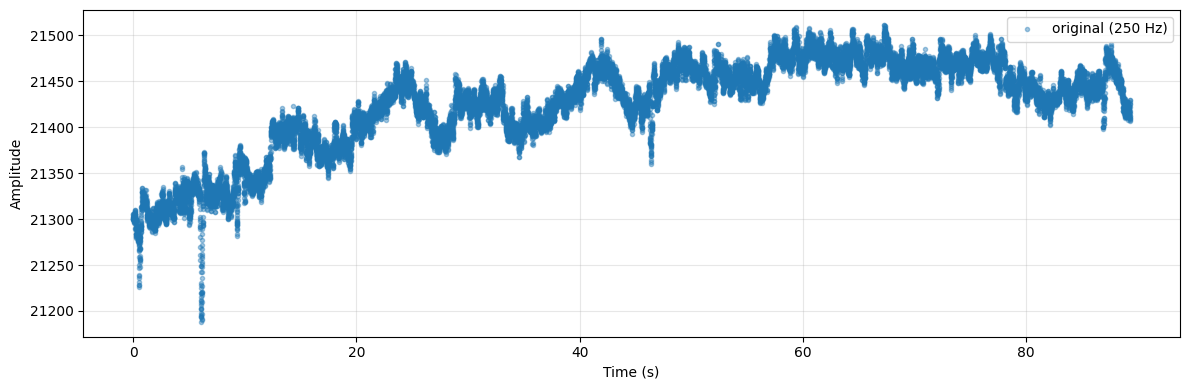

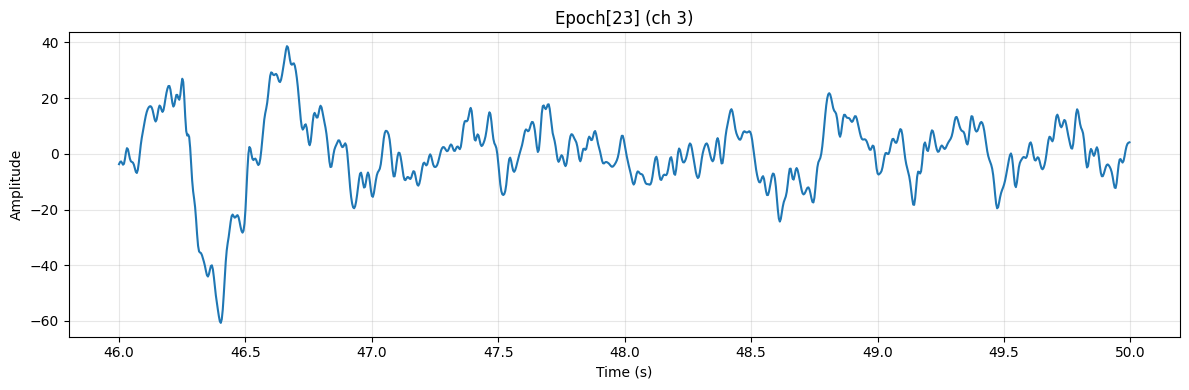

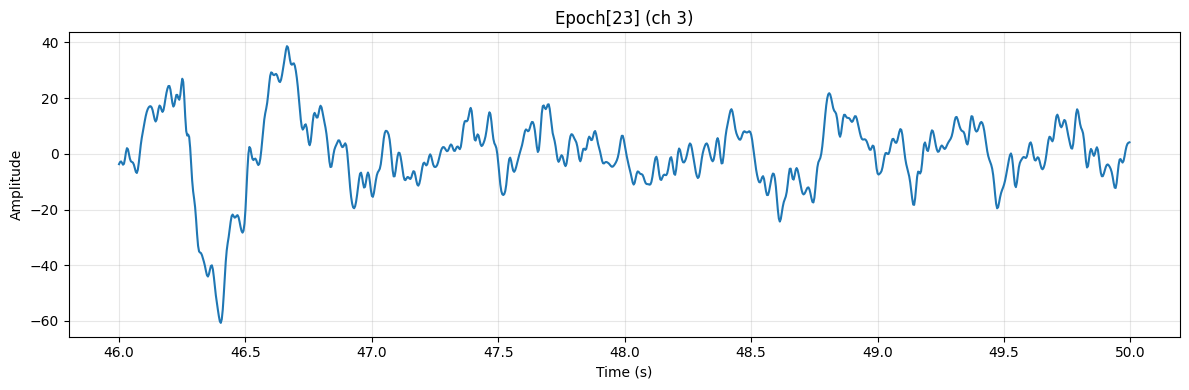

(43, 8, 1024)


In [9]:
task = "Stroop"
level = "lowlevel"
subject = 8

path = find_file(level, task, subject)
X, t = load_ct_matrix(path)

epochs, t_epochs = preprocess_recording(
    X, t,
    debug=True,
    ch_idx=3
)

print(epochs.shape)  # (N, C, win)




## build_all

**definiamo build all usando rec_id**

**Scopo**: oltre a subject, crea anche un ID del recording in modo che si possa fare split “a livello di registrazione” (recording-level) e poi prendere tutte le finestre di quella registrazione insieme

In [10]:

LEVEL_TO_Y = {
    "natural":   0,
    "lowlevel":  1,
    "midlevel":  1,
    "highlevel": 2,
}


In [11]:
def build_all(levels, tasks, subjects, C=8):
    X_list, y_list, subj_list, rec_list = [], [], [], []
    for li, level in enumerate(levels):
        for task in tasks:
            for s in subjects:
                path = find_file(level, task, s)
                if path is None:
                    print(f"[SKIP] missing file: {level}/{task}/S{s}")
                    continue
                try:

                    X, t = load_ct_matrix(path, C=C)
                    epochs, _ = preprocess_recording(X, t=t)
                    if epochs.shape[0]==0:
                        print(f"[SKIP] no epochs: {os.path.basename(path)}")
                        continue

                    rec_id = f"{task}|{level}|S{s}"
                    X_list.append(epochs)
                    y_list.extend([LEVEL_TO_Y[level]] * len(epochs))
                    subj_list.extend([f"S{s}"]*len(epochs))
                    rec_list.extend([rec_id]*len(epochs))
                except Exception as e:
                    print(f"[ERROR] {os.path.basename(path)}: {e}")
                    continue

    X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,C,int(EPOCH_SEC*FS_OUT)), dtype=np.float32)
    y_all = np.array(y_list, dtype=np.int64)
    meta = {
        "subject": np.array(subj_list),
        "rec_id":  np.array(rec_list),
    }
    return X_all, y_all, meta

X_all, y_all, meta = build_all(levels, tasks, subjects, C=8)
print("X_all:", X_all.shape, "y_all:", y_all.shape, "unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024) y_all: (2520,) unique rec: 60


In [12]:
X_all = np.asarray(X_all)
y_all = np.asarray(y_all)

meta["rec_id"]  = np.asarray(meta["rec_id"]).astype(str).reshape(-1)
meta["subject"] = np.asarray(meta["subject"]).astype(str).reshape(-1)

assert len(meta["rec_id"])  == len(y_all) == X_all.shape[0]
assert len(meta["subject"]) == len(y_all)


## recording-level prediction

Questo blocco serve a fare cross-validation a livello di registrazione (non di finestra), mantenendo l’indipendenza tra soggetti, e poi usare quei recording per selezionare le finestre giuste

In [13]:
print("X_all:", X_all.shape)
print("y_all:", y_all.shape, "meta rec:", meta["rec_id"].shape)
print("unique rec:", len(np.unique(meta["rec_id"])))


X_all: (2520, 8, 1024)
y_all: (2520,) meta rec: (2520,)
unique rec: 60


In [14]:
rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)

rec_ids = np.unique(rec_id_win)
rec_to_subj = {rid: rid.split("|")[-1] for rid in rec_ids}  # oppure costruita da meta
rec_subj = np.array([rec_to_subj[r] for r in rec_ids])

# label per recording: prendi la prima finestra e ASSERTA coerenza
rec_y = []
for rid in rec_ids:
    idx = np.where(rec_id_win == rid)[0]
    ys = np.unique(y_all[idx])
    assert len(ys) == 1, f"{rid} ha labels diverse: {ys}"
    rec_y.append(int(ys[0]))
rec_y = np.array(rec_y, dtype=np.int64)

subjects = np.unique(rec_subj)  # es. ["S1",...,"S15"]


WindowDataset e i DataLoader fanno solo tre cose:
- selezionano le finestre giuste con la maschera (rec_id ∈ train_rec/val_rec/test_rec)
- tengono in memoria self.X/self.y/self.r
- in __getitem__ trasformano self.X[i] e self.y[i] in tensori torch

## definizione modello

In [15]:
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 1) Lista ufficiale dei 58 canali (ordine ESATTO EEGPT 58ch) ---
CHANNELS_58 = [
    'FP1','FPZ','FP2',
    'AF3','AF4',
    'F7','F5','F3','F1','FZ','F2','F4','F6','F8',
    'FT7','FC5','FC3','FC1','FCZ','FC2','FC4','FC6','FT8',
    'T7','C5','C3','C1','CZ','C2','C4','C6','T8',
    'TP7','CP5','CP3','CP1','CPZ','CP2','CP4','CP6','TP8',
    'P7','P5','P3','P1','PZ','P2','P4','P6','P8',
    'PO7','PO3','POZ','PO4','PO8',
    'O1','OZ','O2'
]
assert len(CHANNELS_58) == 58

# --- 2) I tuoi 8 canali ---
my_channels = ["Fp1","Fp2","F7","F3","FZ","F4","F8","C2"]
use_channels_8 = [c.upper().strip('.') for c in my_channels]

# Mappa: nome_canale -> indice nel vettore 58
idx58 = {ch: i for i, ch in enumerate(CHANNELS_58)}

# Sanity check
for ch in use_channels_8:
    assert ch in idx58, f"Canale {ch} non è nei 58 canali EEGPT"

chan_ids_8 = [idx58[ch] for ch in use_channels_8]
print("8ch:", use_channels_8)
print("chan_ids_8 (posizioni nel 58):", chan_ids_8)

# --- 3) Embedding 8 -> 58 (baseline: zero-fill canali mancanti) ---
def embed_8_to_58(xb_8: torch.Tensor, chan_ids_8: list[int]) -> torch.Tensor:
    """
    xb_8: (B, 8, T) nei canali nell'ordine di use_channels_8
    ritorna: (B, 58, T) nell'ordine CHANNELS_58
    """
    assert xb_8.ndim == 3, "xb_8 deve essere (B,8,T)"
    B, C8, T = xb_8.shape
    assert C8 == 8, f"attesi 8 canali, trovati {C8}"
    xb_58 = torch.zeros((B, 58, T), device=xb_8.device, dtype=xb_8.dtype)
    xb_58[:, chan_ids_8, :] = xb_8
    return xb_58

# --- 4) Estrazione feature EEGPT ---
@torch.no_grad()
def extract_eegpt_features(model, loader, device, chan_ids_8):
    """
    loader deve restituire: xb, yb, rid
    xb: (B,8,T)
    """
    feats_all, y_all_out, rec_all = [], [], []
    for xb, yb, rid in loader:
        xb = xb.to(device).float()           # (B,8,T)
        xb58 = embed_8_to_58(xb, chan_ids_8) # (B,58,T)

        feats = model.forward_features(xb58) # (B,D) se così è definito nel tuo EEGPTClassifier
        feats_all.append(feats.detach().cpu())
        y_all_out.append(yb.detach().cpu())

        # rid può essere list/np/torch: normalizziamo a stringhe
        if isinstance(rid, torch.Tensor):
            rid = rid.detach().cpu().numpy()
        rec_all.extend(list(np.asarray(rid).astype(str)))

    return torch.cat(feats_all, 0), torch.cat(y_all_out, 0), np.asarray(rec_all, dtype=str)





Device: cuda
8ch: ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'C2']
chan_ids_8 (posizioni nel 58): [0, 2, 5, 7, 9, 11, 13, 28]


In [16]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)





Device: cuda


In [17]:



model = EEGPTClassifier(
    num_classes=3,
    in_channels=58,
    img_size=[58, 1024],
    patch_stride=128,
    desired_time_len=1024,
    use_channels_names=CHANNELS_58,
    ckpt_path=str(ckpt_path),
).to(device)

model.eval()
for p in model.parameters():
    p.requires_grad = False
print("Model ready.")




Model ready.


## LOSO

### LogitAdjustedCE

In [18]:
import sympy, sys
print("sympy version:", getattr(sympy, "__version__", "NO_VERSION"))
print("sympy file:", getattr(sympy, "__file__", "NO_FILE"))
print("sys.path[0]:", sys.path[0])


sympy version: 1.12.1
sympy file: /usr/local/lib/python3.12/dist-packages/sympy/__init__.py
sys.path[0]: /content



LOSO RECORDING-LEVEL (log-mean pooled logits)
Confusion matrix:
 [[10  4  1]
 [ 5 16  9]
 [ 1  7  7]]

Report:
               precision    recall  f1-score   support

           0      0.625     0.667     0.645        15
           1      0.593     0.533     0.561        30
           2      0.412     0.467     0.438        15

    accuracy                          0.550        60
   macro avg      0.543     0.556     0.548        60
weighted avg      0.555     0.550     0.551        60

Balanced Accuracy: 0.5555555555555555
Accuracy: 0.55

LOSO WINDOW-LEVEL
Confusion matrix:
 [[457 212 166]
 [215 372 354]
 [134 259 351]]

Report:
               precision    recall  f1-score   support

           0      0.567     0.547     0.557       835
           1      0.441     0.395     0.417       941
           2      0.403     0.472     0.435       744

    accuracy                          0.468      2520
   macro avg      0.470     0.471     0.470      2520
weighted avg      0.472     0.468

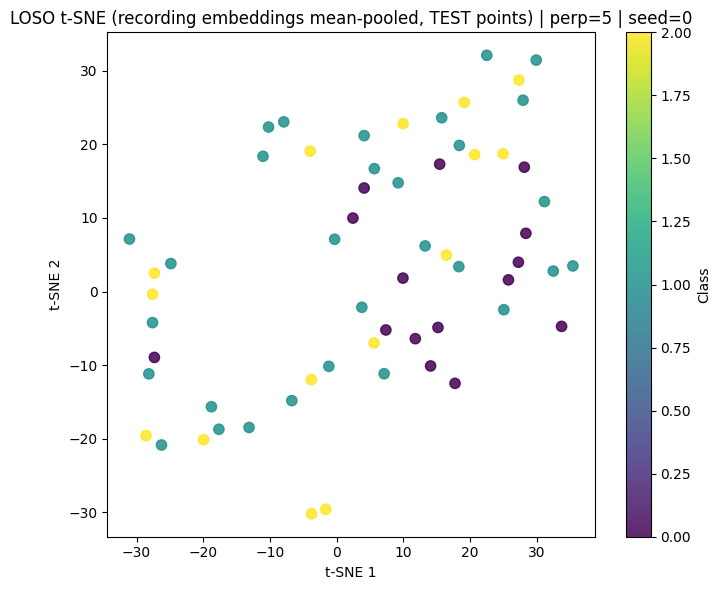

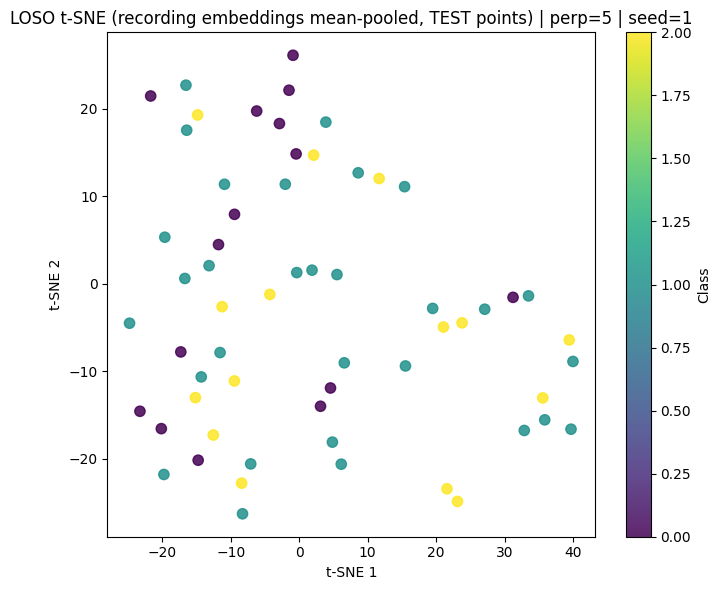

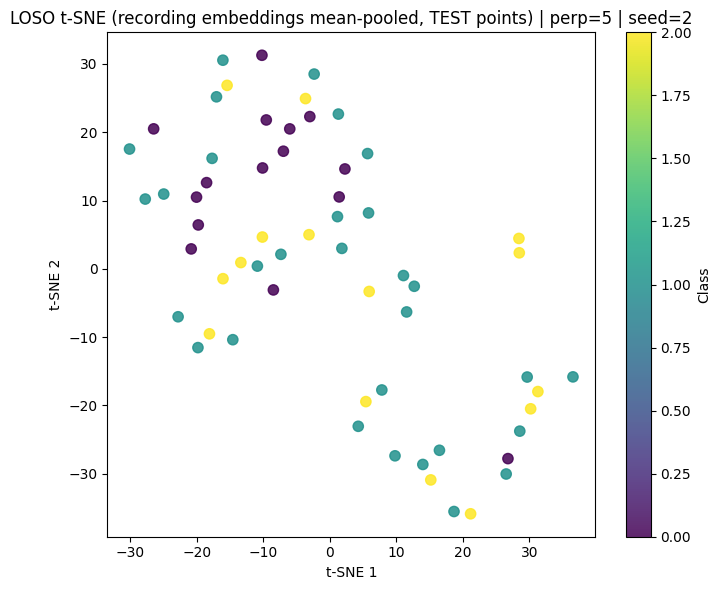

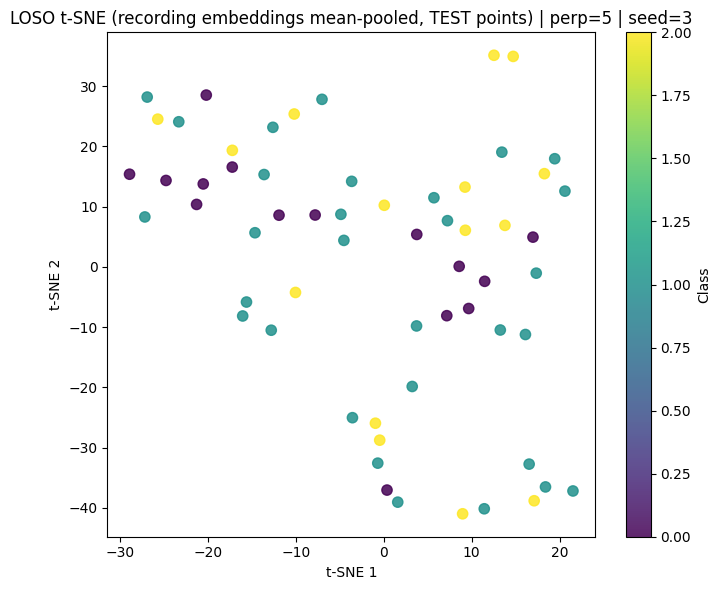

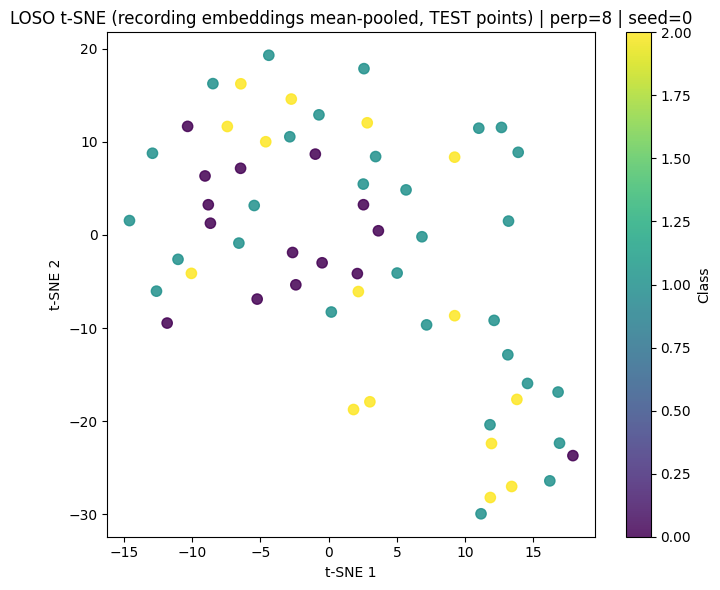

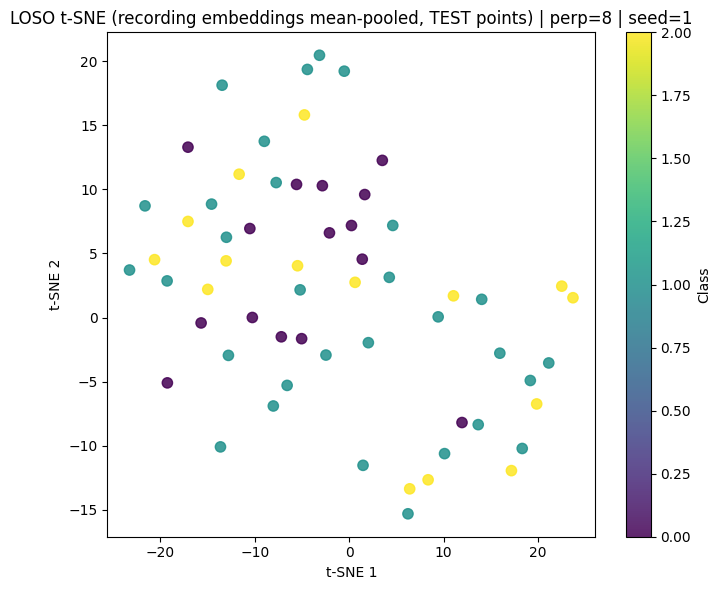

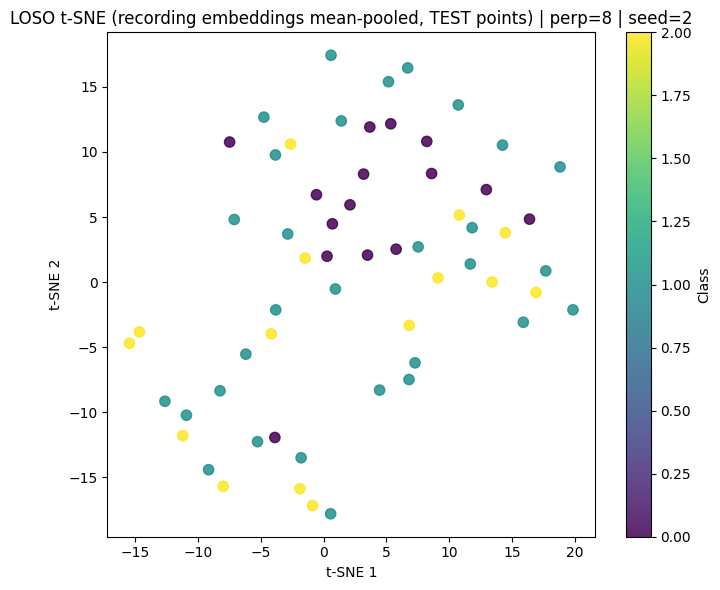

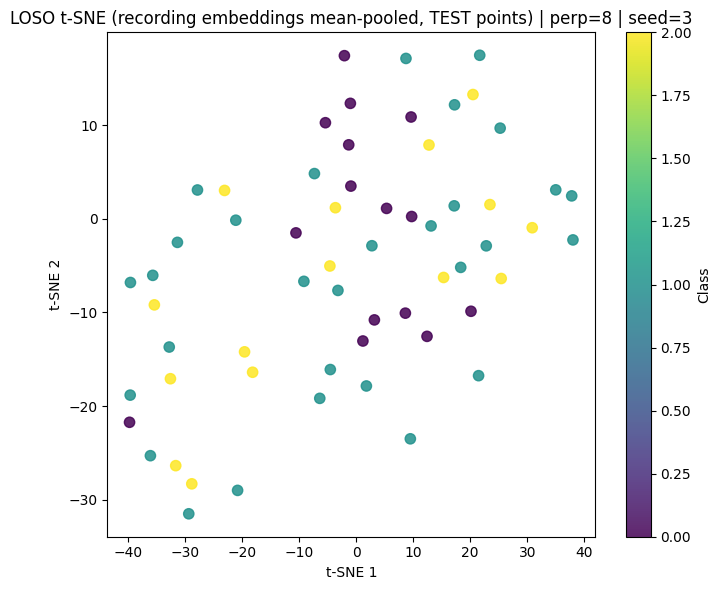

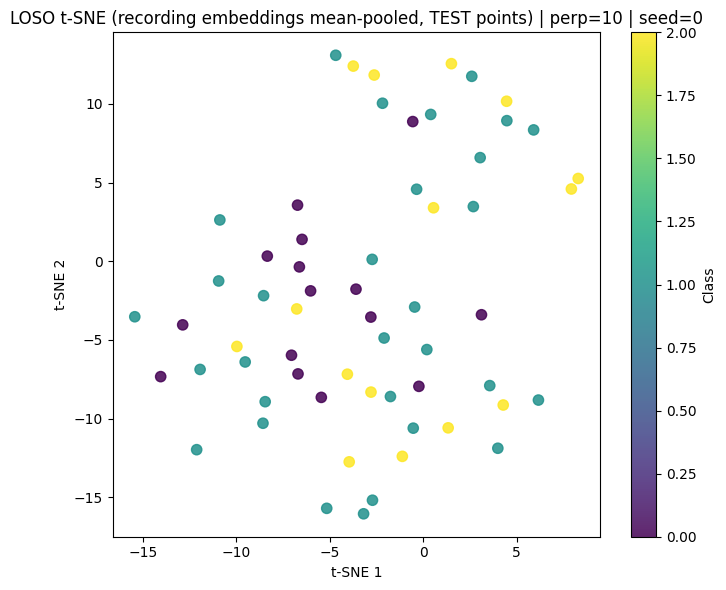

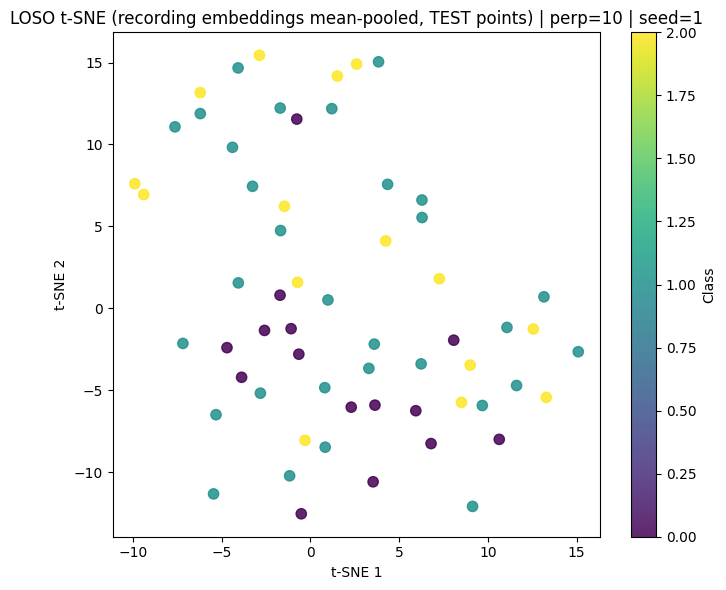

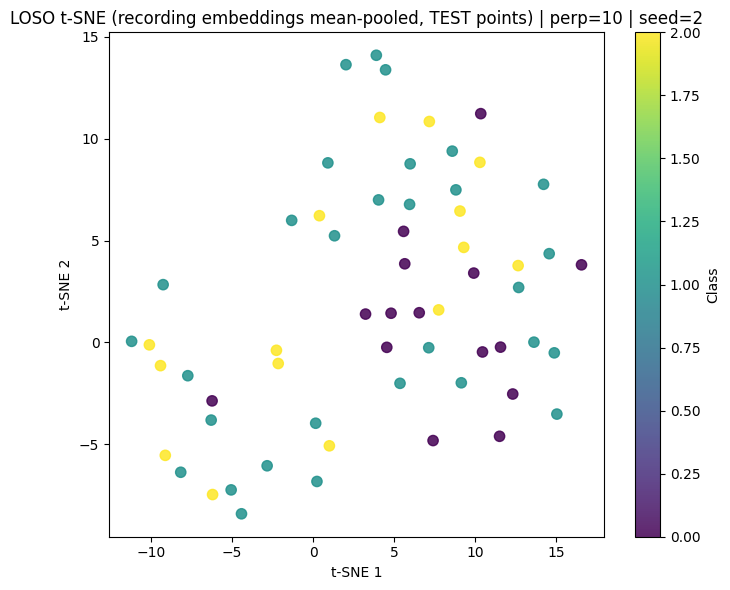

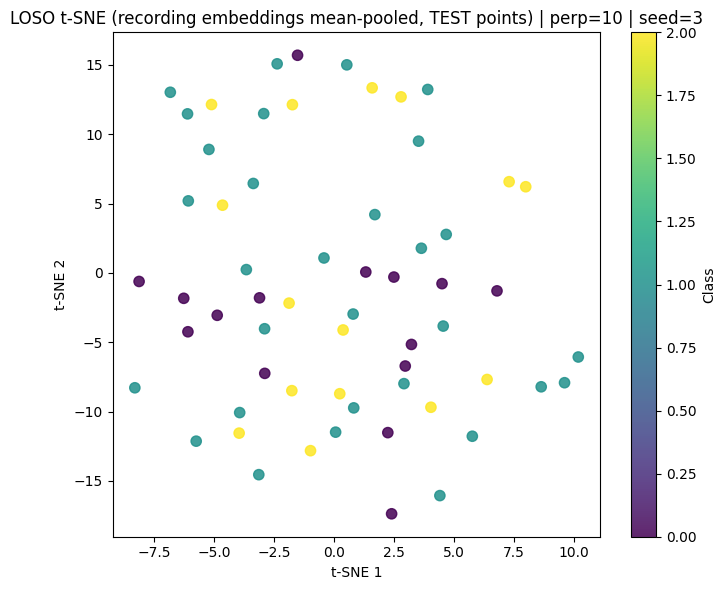

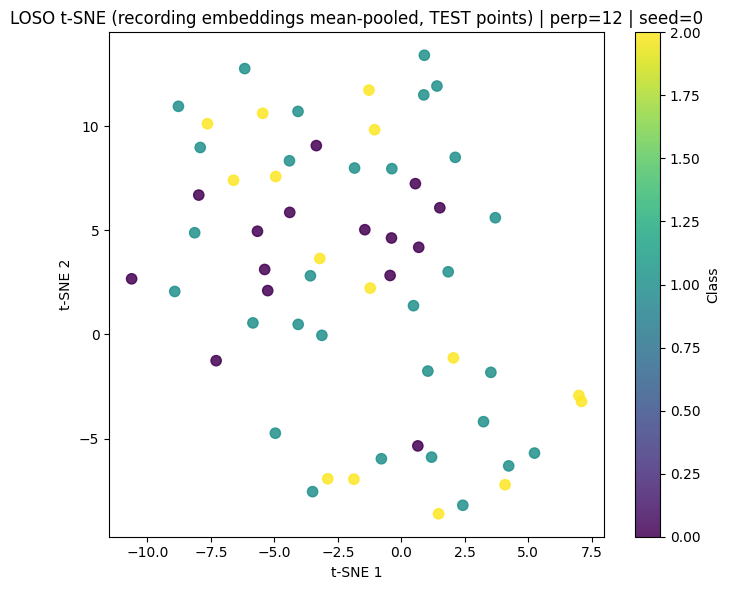

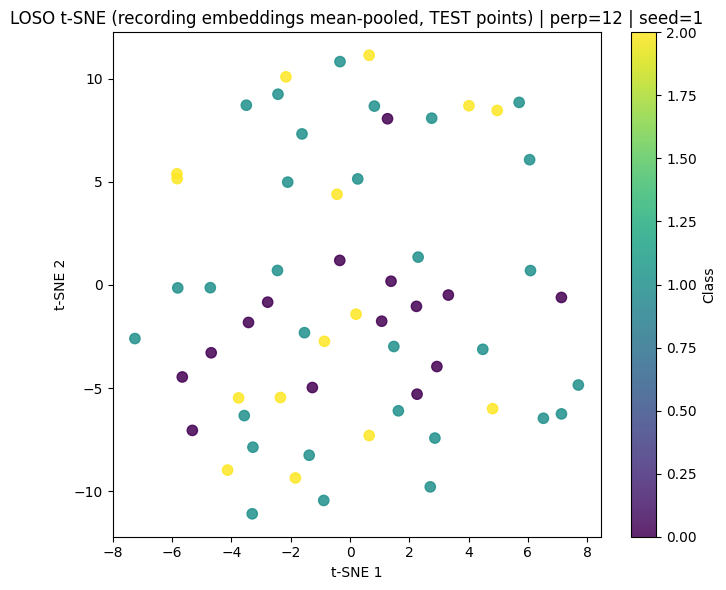

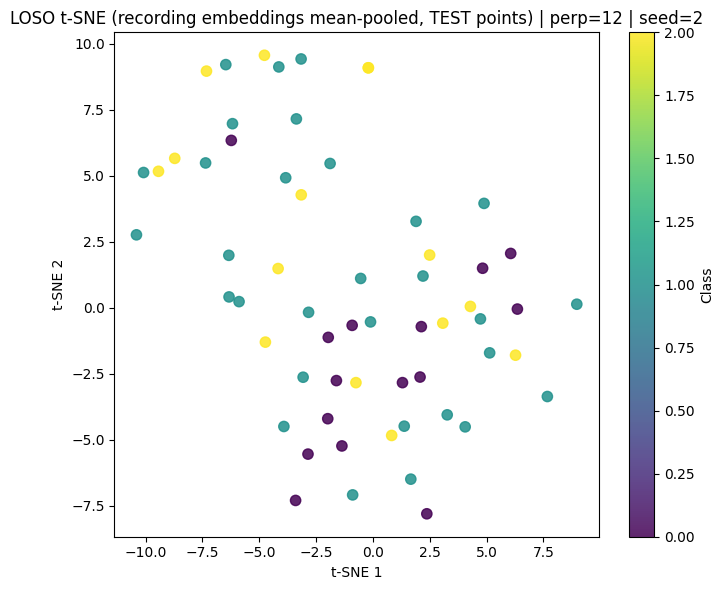

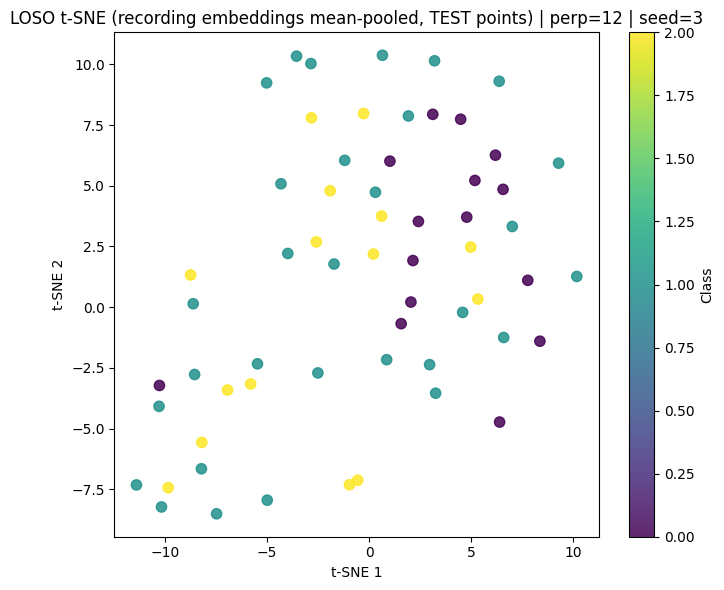

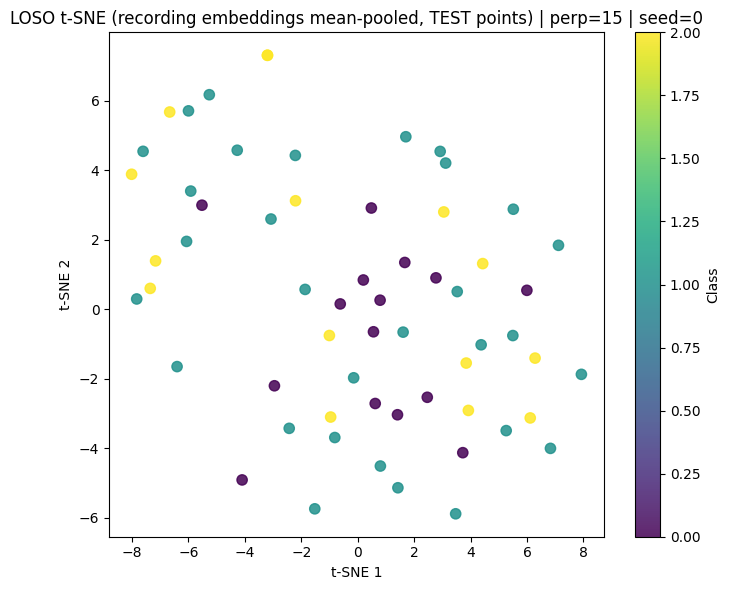

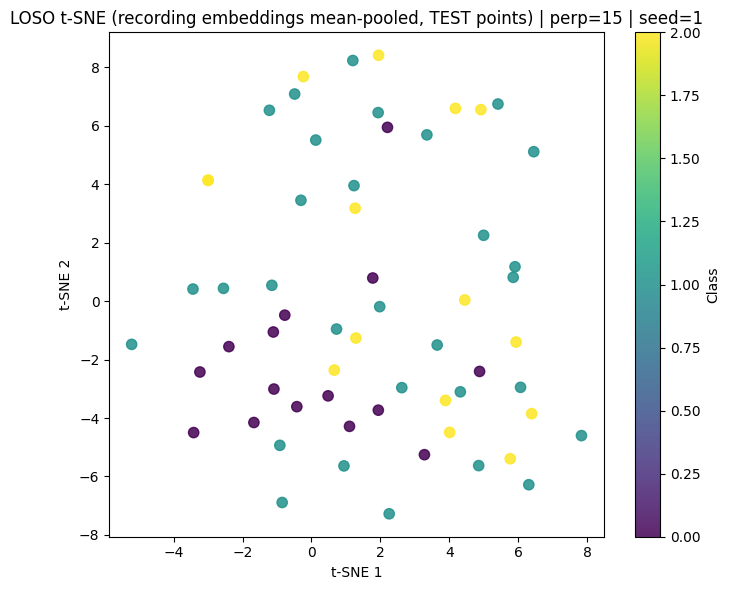

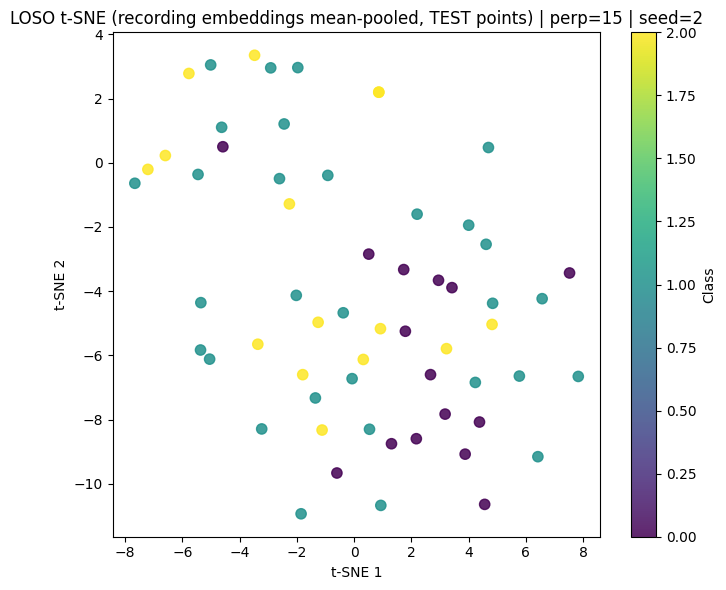

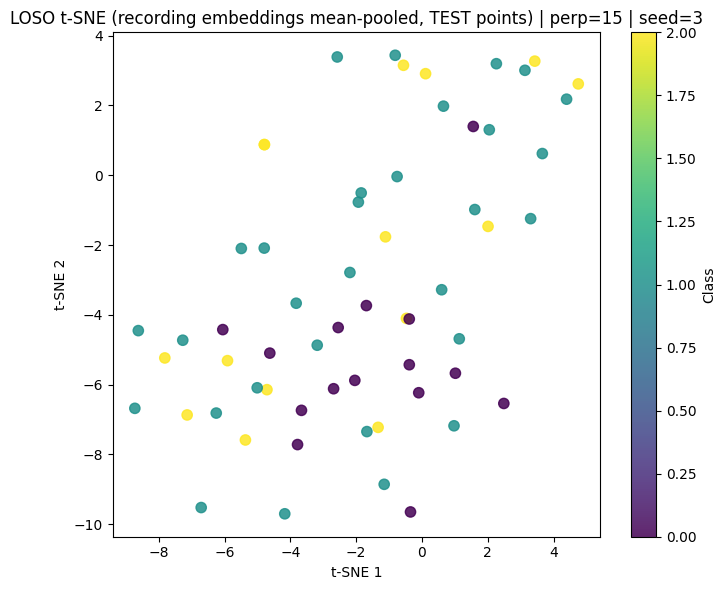

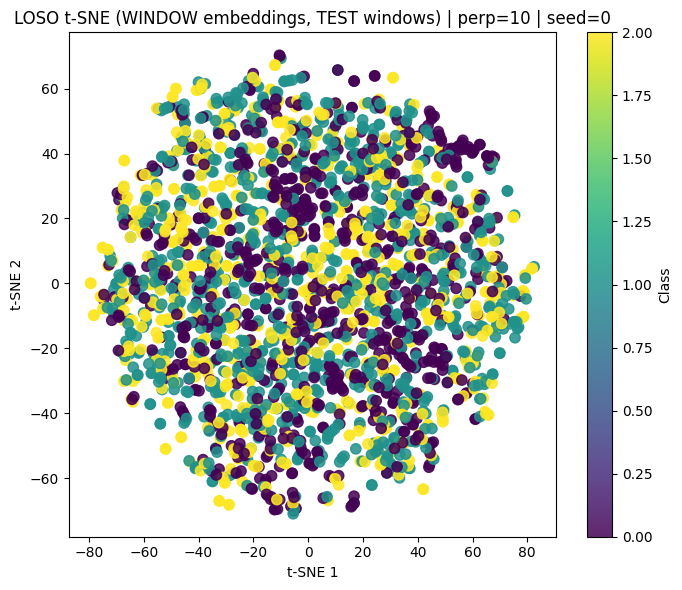

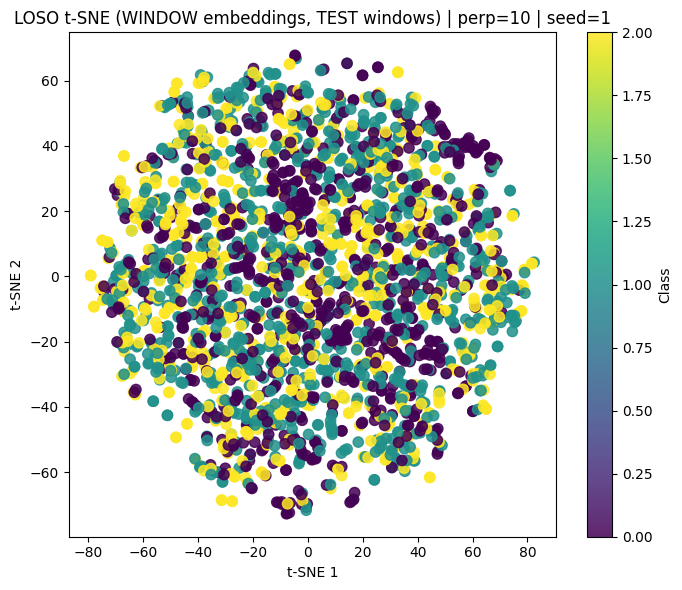

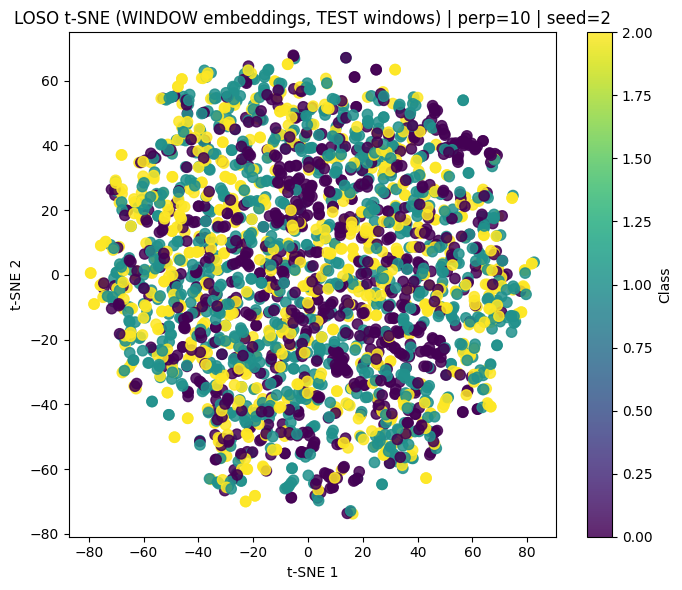

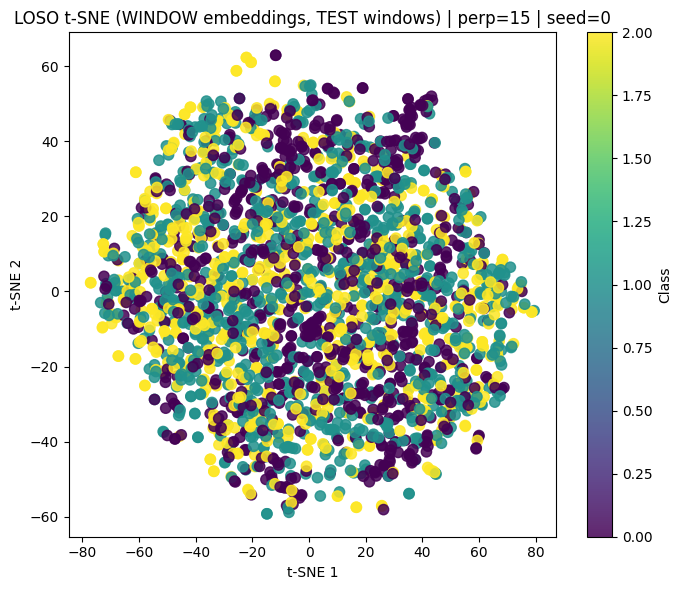

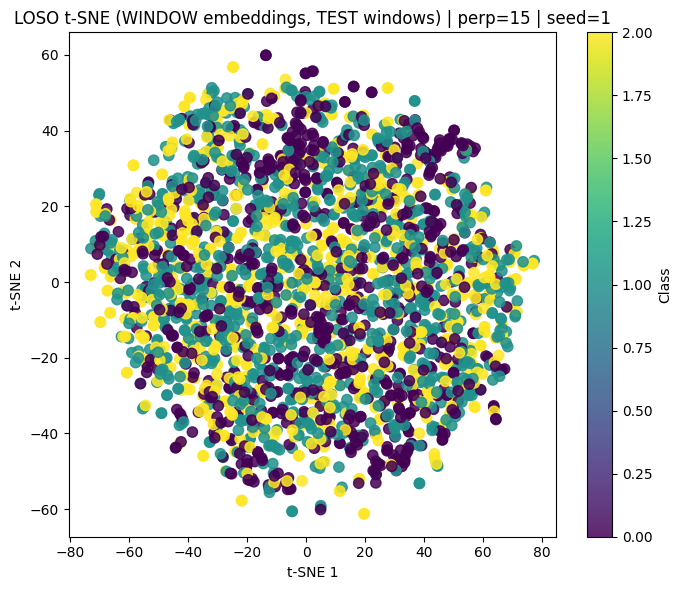

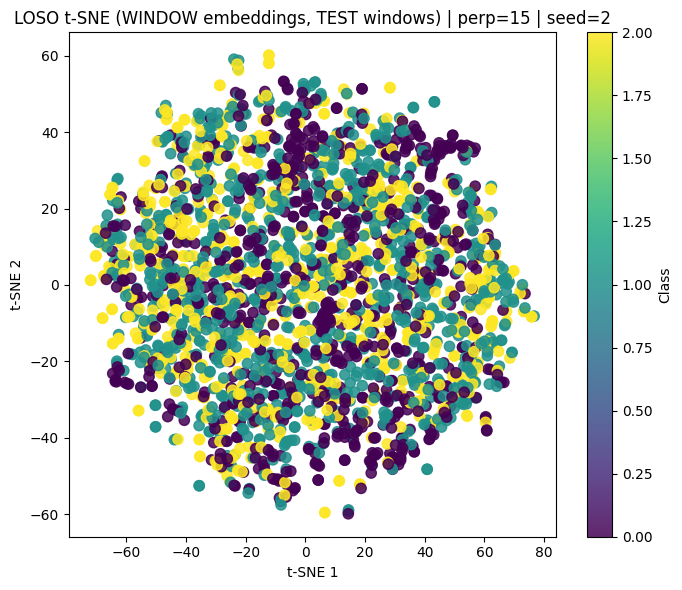

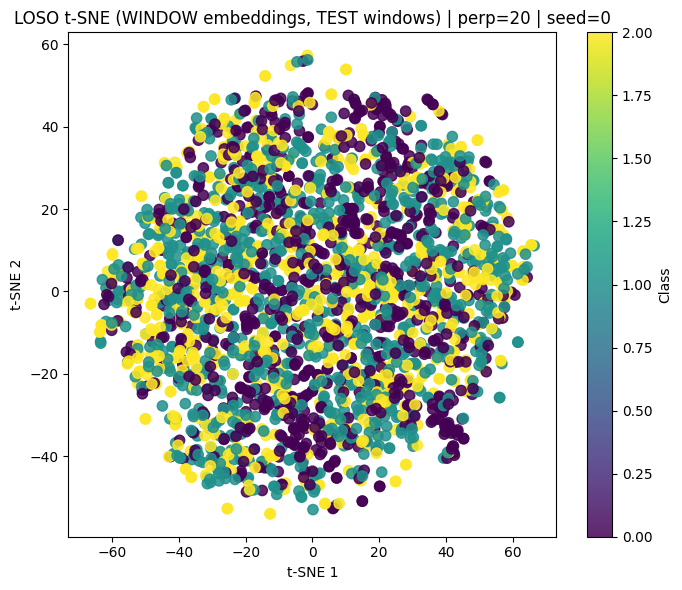

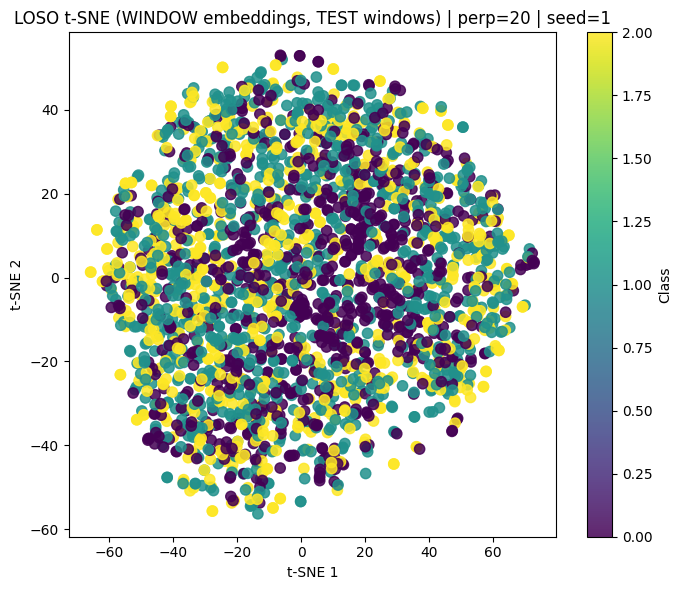

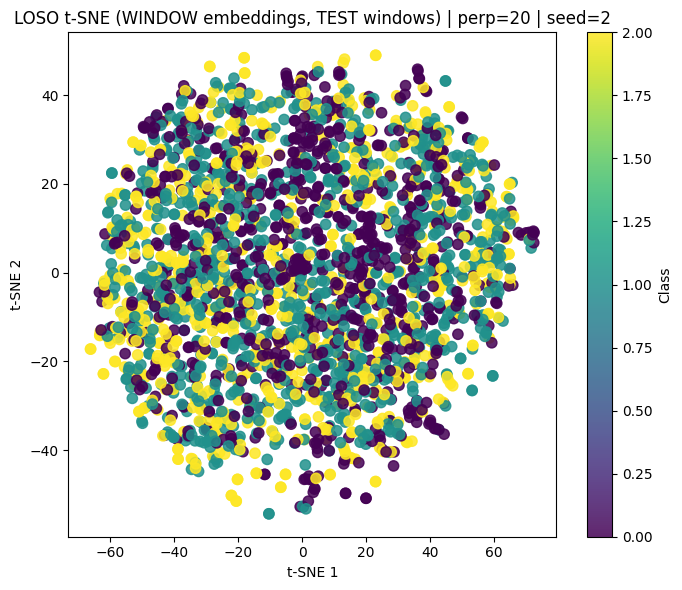

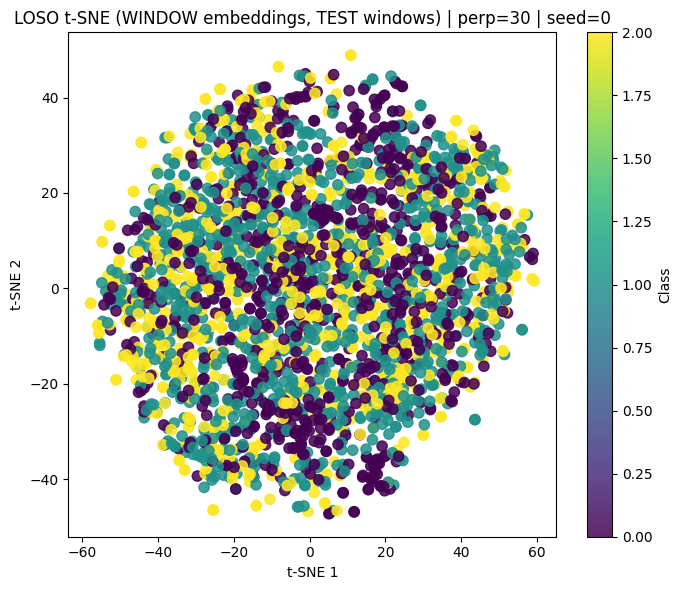

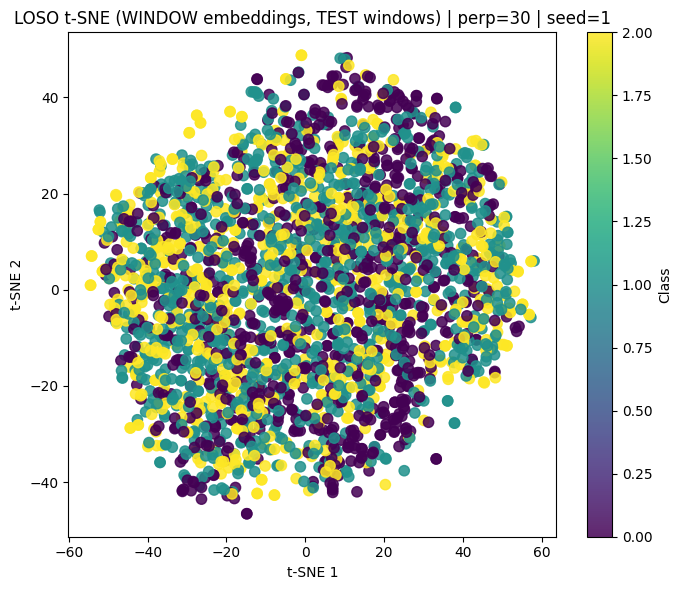

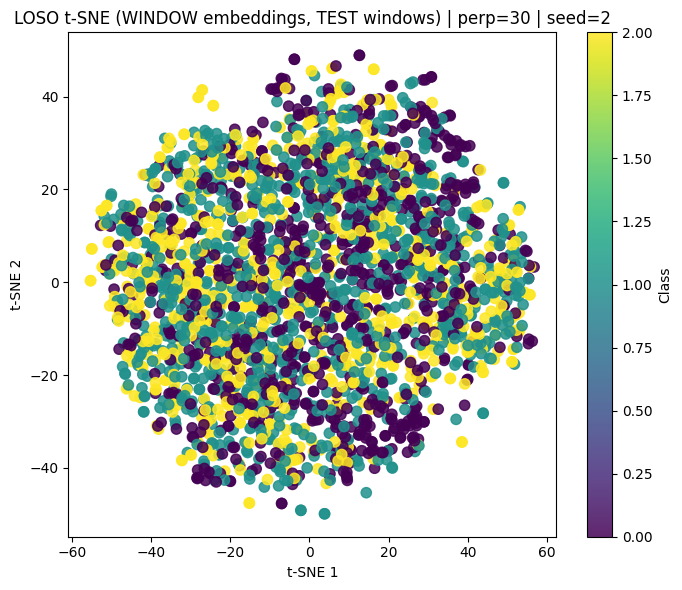

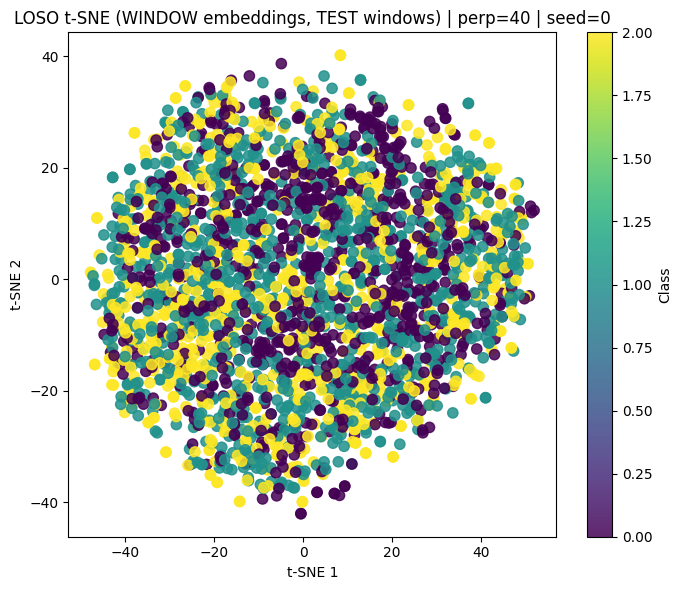

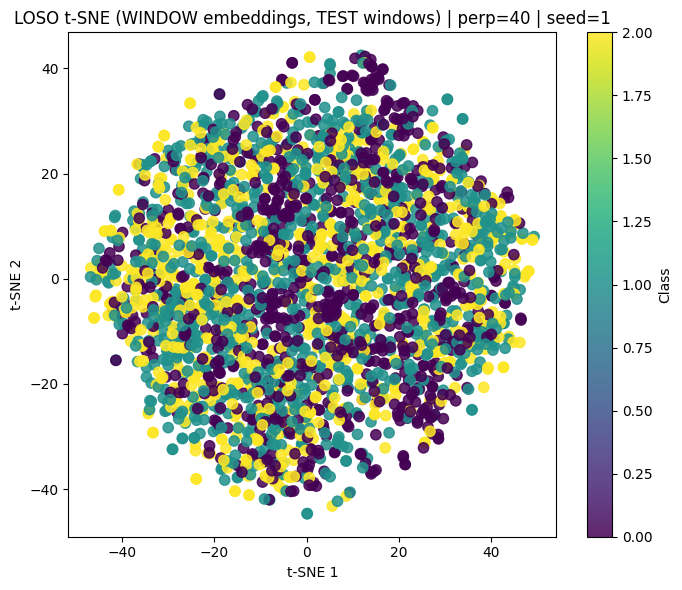

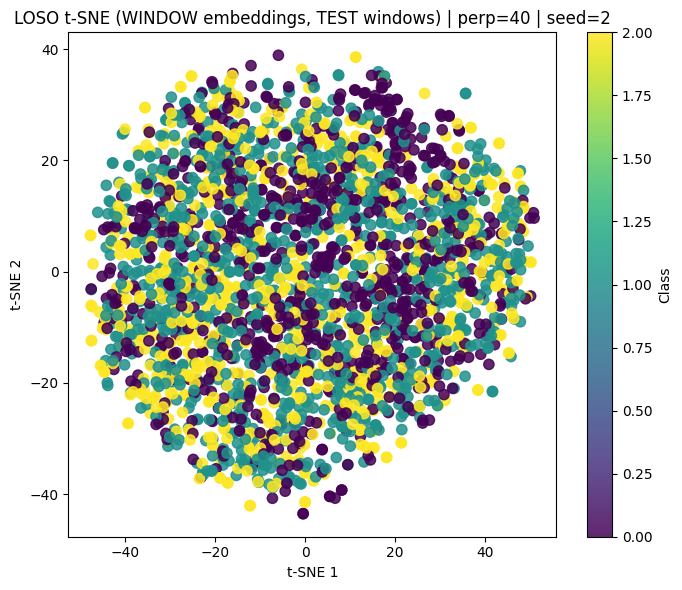

In [19]:
# ============================================================
# EEGPT LOSO (single training on WINDOWS) + recording via log-mean pooling
# - Train ONE classifier per LOSO fold on window embeddings (imbalance-aware LogitAdjustedCE)
# - Window prediction: argmax(logits)
# - Recording prediction: mean(log_softmax(logits)) per rec_id (no second training)
# - t-SNE: optional (windows + pooled recordings) for visualization only
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    accuracy_score
)

# ============================================================
# Utils
# ============================================================

def to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def to_str_np(x):
    return np.asarray(to_np(x)).astype(str).reshape(-1)

def recording_pool_logmean_from_logits(logits_np, rec_ids):
    """
    logits_np: (Nwin, C) numpy logits per window
    rec_ids:   (Nwin,)   rec_id per window (str)
    Returns:
      rec_list: (Nrec,)
      rec_pred: (Nrec,)
      rec_logscore: (Nrec, C) mean log-prob for each rec
    """
    rec_ids = np.asarray(rec_ids).astype(str).reshape(-1)
    logits_np = np.asarray(logits_np)

    uniq = np.unique(rec_ids)
    rec_logscore = []
    for rid in uniq:
        m = (rec_ids == rid)
        L = torch.tensor(logits_np[m], dtype=torch.float32)  # (m, C)
        logp = F.log_softmax(L, dim=1)                       # (m, C)
        agg = logp.mean(dim=0)                               # (C,)
        rec_logscore.append(agg)

    rec_logscore = torch.stack(rec_logscore, dim=0).cpu().numpy()  # (Nrec, C)
    rec_pred = rec_logscore.argmax(axis=1)
    return uniq, rec_pred, rec_logscore

def recording_true_from_windows(y_win, rec_ids, rec_list):
    y_win = np.asarray(y_win).astype(int).reshape(-1)
    rec_ids = np.asarray(rec_ids).astype(str).reshape(-1)
    y_rec = []
    for rid in rec_list:
        y_rec.append(int(y_win[rec_ids == rid][0]))  # assumes constant label per recording
    return np.asarray(y_rec, dtype=int)

def pool_by_recording_torch(feat, y, rec):
    """
    ONLY for visualization (t-SNE): mean pool embeddings per recording.
    feat: torch (Nwin, D)
    y:    torch (Nwin,)
    rec:  list/np (Nwin,)
    """
    rec = np.asarray(rec).astype(str)
    uniq = np.unique(rec)
    Xr, Yr = [], []
    for rid in uniq:
        m = (rec == rid)
        Xr.append(feat[m].mean(dim=0))
        Yr.append(int(y[m][0].item()))
    return torch.stack(Xr, 0), torch.tensor(Yr, dtype=torch.long), uniq

# ============================================================
# MLP classifier
# ============================================================

class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x):
        return self.net(x)

# ============================================================
# Loss: LogitAdjustedCE
# NOTE: if you already have it defined elsewhere, you can remove this block.
# ============================================================

class LogitAdjustedCE(nn.Module):
    """
    Logit-adjusted cross entropy:
      loss = CE(logits + tau * log(prior), y)
    where prior = counts / sum(counts).
    """
    def __init__(self, counts, tau=1.0, eps=1e-12):
        super().__init__()
        counts = np.asarray(counts, dtype=np.float64)
        prior = counts / max(counts.sum(), 1.0)
        prior = np.clip(prior, eps, 1.0)
        self.register_buffer("adj", torch.tensor(np.log(prior), dtype=torch.float32))
        self.tau = float(tau)

    def forward(self, logits, y):
        return F.cross_entropy(logits + self.tau * self.adj, y)

# ============================================================
# Train ONE classifier on windows (imbalance-aware) with early stopping on val balanced acc
# ============================================================

def train_mlp_with_val(Xtr_np, ytr_np, Xva_np, yva_np, num_classes, device,
                       max_epochs=300, patience=30, lr=1e-3, wd=1e-4, tau=1.0):

    Xtr = torch.tensor(Xtr_np, dtype=torch.float32).to(device)
    Xva = torch.tensor(Xva_np, dtype=torch.float32).to(device)
    ytr = torch.tensor(ytr_np, dtype=torch.long).to(device)
    yva = torch.tensor(yva_np, dtype=torch.long).to(device)

    clf = MLP(Xtr.shape[1], num_classes).to(device)

    counts = np.bincount(np.asarray(ytr_np).astype(int), minlength=num_classes)
    crit = LogitAdjustedCE(counts, tau=tau).to(device)
    opt  = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)

    @torch.no_grad()
    def val_balacc():
        clf.eval()
        pred = clf(Xva).argmax(1).detach().cpu().numpy()
        true = yva.detach().cpu().numpy()
        return balanced_accuracy_score(true, pred)

    best, best_state, noimp = -1, None, 0
    for _ in range(max_epochs):
        clf.train()
        opt.zero_grad(set_to_none=True)
        loss = crit(clf(Xtr), ytr)
        loss.backward()
        opt.step()

        va = val_balacc()
        if va > best:
            best = va
            best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
            noimp = 0
        else:
            noimp += 1
            if noimp >= patience:
                break

    if best_state is not None:
        clf.load_state_dict(best_state)
    return clf

# ============================================================
# Dataset
# ============================================================

class WindowDataset(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        X_all = np.asarray(X_all)
        y_all = np.asarray(y_all)

        rec_id_all = np.asarray(rec_id_all).astype(str).reshape(-1)
        assert len(rec_id_all) == len(y_all) == X_all.shape[0], \
            f"Mismatch: rec_id={len(rec_id_all)} y={len(y_all)} X={X_all.shape}"

        mask = np.isin(rec_id_all, list(keep_rec_set))
        self.X = X_all[mask]
        self.y = y_all[mask]
        self.r = rec_id_all[mask]

    def __len__(self): return len(self.y)

    def __getitem__(self, i):
        return (torch.tensor(self.X[i], dtype=torch.float32),
                torch.tensor(self.y[i], dtype=torch.long),
                self.r[i])

# ============================================================
# t-SNE sweep utility
# ============================================================

def tsne_sweep(X_np, y_np, title_prefix, perplexities, seeds, pca_dim=30):
    X_np = np.asarray(X_np)
    y_np = np.asarray(y_np).astype(int).reshape(-1)
    assert len(X_np) == len(y_np)

    Xz = StandardScaler().fit_transform(X_np)
    k = min(pca_dim, Xz.shape[1])
    Xp = PCA(n_components=k, random_state=0).fit_transform(Xz)

    for perp in perplexities:
        if perp >= (len(Xp) - 1) / 3:
            continue
        for seed in seeds:
            X2 = TSNE(
                n_components=2,
                perplexity=perp,
                init="pca",
                learning_rate="auto",
                random_state=seed
            ).fit_transform(Xp)

            plt.figure(figsize=(7, 6))
            sc = plt.scatter(X2[:, 0], X2[:, 1], c=y_np, s=55, alpha=0.85)
            plt.colorbar(sc, label="Class")
            plt.title(f"{title_prefix} | perp={perp} | seed={seed}")
            plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
            plt.tight_layout()
            plt.show()

# ============================================================
# MAIN: LOSO
# ============================================================
# REQUIREMENTS you must already have:
# - X_all, y_all
# - meta["rec_id"], meta["subject"]
# - model, chan_ids_8
# - extract_eegpt_features(model, loader, device, chan_ids_8)
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 64

rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)

rec_ids_all = rec_id_win
subj_all    = subj_win
subjects    = np.unique(subj_all)

num_classes = int(np.max(y_all) + 1)

all_true, all_pred = [], []                 # recording-level
all_true_win, all_pred_win = [], []         # window-level

# t-SNE caches (visualization only)
DO_WINDOWS_TSNE = True
MAX_WIN_TSNE_PER_SUBJ = 500
all_Xte_rec, all_yte_rec = [], []
all_Xte_win, all_yte_win = [], []

# Map recording -> subject (using first window of that recording)
rec_ids = np.unique(rec_id_win)
rec_to_subj = {}
for rid in rec_ids:
    idx = np.where(rec_id_win == rid)[0][0]
    rec_to_subj[rid] = subj_win[idx]

for s in subjects:
    # TEST recordings of subject s
    test_rec = set(np.unique(rec_ids_all[subj_all == s]))

    # TRAINVAL recordings of other subjects
    trainval_rec = np.unique(rec_ids_all[subj_all != s])

    # split train/val recordings grouped by subject
    trainval_subj = np.array([rec_to_subj[rid] for rid in trainval_rec])
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subj))
    train_rec = set(trainval_rec[tr_idx])
    val_rec   = set(trainval_rec[va_idx])

    # datasets & loaders (WINDOW level)
    train_ds = WindowDataset(X_all, y_all, rec_ids_all, train_rec)
    val_ds   = WindowDataset(X_all, y_all, rec_ids_all, val_rec)
    test_ds  = WindowDataset(X_all, y_all, rec_ids_all, test_rec)

    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=False)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

    # Extract EEGPT window embeddings
    tr_feat, tr_y, tr_rec = extract_eegpt_features(model, train_loader, device, chan_ids_8)
    va_feat, va_y, va_rec = extract_eegpt_features(model, val_loader,   device, chan_ids_8)
    te_feat, te_y, te_rec = extract_eegpt_features(model, test_loader,  device, chan_ids_8)

    # ------------------------------------------------------------
    # SINGLE TRAINING on WINDOWS + RECORDING via log-mean pooling
    # ------------------------------------------------------------
    Xtr_w = to_np(tr_feat)
    Xva_w = to_np(va_feat)
    Xte_w = to_np(te_feat)

    ytr_w = to_np(tr_y).astype(int)
    yva_w = to_np(va_y).astype(int)
    yte_w = to_np(te_y).astype(int)

    # scale windows (fit train only)
    scaler_w = StandardScaler()
    Xtr_w_np = scaler_w.fit_transform(Xtr_w)
    Xva_w_np = scaler_w.transform(Xva_w)
    Xte_w_np = scaler_w.transform(Xte_w)

    # train ONE clf on windows (imbalance-aware)
    clf = train_mlp_with_val(
        Xtr_w_np, ytr_w,
        Xva_w_np, yva_w,
        num_classes=num_classes,
        device=device,
        tau=1.0
    )

    # test logits + window preds
    with torch.no_grad():
        clf.eval()
        Xte_t = torch.tensor(Xte_w_np, dtype=torch.float32).to(device)
        logits_te_t = clf(Xte_t)  # (Nwin_te, C)

    logits_te = logits_te_t.detach().cpu().numpy()
    pred_win  = logits_te.argmax(axis=1)

    all_true_win.extend(yte_w.tolist())
    all_pred_win.extend(pred_win.tolist())

    # recording preds via correct pooling (NO retrain)
    rec_list, pred_rec, _ = recording_pool_logmean_from_logits(logits_te, te_rec)
    true_rec = recording_true_from_windows(yte_w, te_rec, rec_list)

    all_true.extend(true_rec.tolist())
    all_pred.extend(pred_rec.tolist())

    # ------------------------------------------------------------
    # t-SNE caches (visualization only)
    # ------------------------------------------------------------
    # recording points: mean-pooled embeddings per rec (for plotting only)
    X_te_rec_vis, y_te_rec_vis, _ = pool_by_recording_torch(te_feat, te_y, te_rec)
    all_Xte_rec.append(to_np(X_te_rec_vis))
    all_yte_rec.append(to_np(y_te_rec_vis))

    # window points: subsample embeddings per subject (for plotting only)
    if DO_WINDOWS_TSNE:
        Xw = Xte_w
        yw = yte_w
        if len(Xw) > MAX_WIN_TSNE_PER_SUBJ:
            rs = np.random.RandomState(0)
            idx = rs.choice(len(Xw), size=MAX_WIN_TSNE_PER_SUBJ, replace=False)
            Xw = Xw[idx]
            yw = yw[idx]
        all_Xte_win.append(Xw)
        all_yte_win.append(yw)

# ============================================================
# FINAL REPORTS
# ============================================================

print("\n==============================")
print("LOSO RECORDING-LEVEL (log-mean pooled logits)")
print("==============================")
cm = confusion_matrix(all_true, all_pred, labels=list(range(num_classes)))
print("Confusion matrix:\n", cm)
print("\nReport:\n", classification_report(all_true, all_pred, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true, all_pred))
print("Accuracy:", accuracy_score(all_true, all_pred))

print("\n==============================")
print("LOSO WINDOW-LEVEL")
print("==============================")
cm_w = confusion_matrix(all_true_win, all_pred_win, labels=list(range(num_classes)))
print("Confusion matrix:\n", cm_w)
print("\nReport:\n", classification_report(all_true_win, all_pred_win, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true_win, all_pred_win))
print("Accuracy:", accuracy_score(all_true_win, all_pred_win))

# ============================================================
# FINAL t-SNE (optional)
# ============================================================

# recording-level t-SNE (pooled embeddings, TEST points)
X_tsne_rec = np.concatenate(all_Xte_rec, axis=0)
y_tsne_rec = np.concatenate(all_yte_rec, axis=0)

tsne_sweep(
    X_tsne_rec, y_tsne_rec,
    title_prefix="LOSO t-SNE (recording embeddings mean-pooled, TEST points)",
    perplexities=(5, 8, 10, 12, 15),
    seeds=(0, 1, 2, 3),
    pca_dim=30
)

# windows t-SNE (TEST windows across all LOSO iters)
if DO_WINDOWS_TSNE and len(all_Xte_win) > 0:
    X_tsne_win = np.concatenate(all_Xte_win, axis=0)
    y_tsne_win = np.concatenate(all_yte_win, axis=0)

    tsne_sweep(
        X_tsne_win, y_tsne_win,
        title_prefix="LOSO t-SNE (WINDOW embeddings, TEST windows)",
        perplexities=(10, 15, 20, 30, 40),
        seeds=(0, 1, 2),
        pca_dim=30
    )



# FDA

## A) Helper: estrarre finestre e rec_id dal Dataset (senza torch siccome non supportato da FDA)

In [20]:
import numpy as np

def get_numpy_from_ds(ds):
    """
    ds: WindowDataset
    returns:
      X: (Nwin, C, T) float32
      y: (Nwin,) int64
      rec: (Nwin,) array dtype object/str
    """
    X = ds.X.astype(np.float32)
    y = ds.y.astype(np.int64)
    rec = np.asarray(ds.r)
    return X, y, rec


## B) Pooling per recording (uguale al tuo TSN pooling, ma numpy)

In [21]:
def pool_by_recording(X_feat, y_win, rec_ids, agg="mean"):
    """
    X_feat: (Nwin, p)
    y_win : (Nwin,)
    rec_ids: (Nwin,) strings or objects
    returns:
      X_rec: (Nrec, p)
      y_rec: (Nrec,)
      rec_uniq: (Nrec,)
    """
    rec_ids = np.asarray(rec_ids).astype(str)
    uniq = np.unique(rec_ids)
    Xr, Yr = [], []
    for rid in uniq:
        m = (rec_ids == rid)
        if agg == "mean":
            Xr.append(X_feat[m].mean(axis=0))
        elif agg == "median":
            Xr.append(np.median(X_feat[m], axis=0))
        else:
            raise ValueError("agg must be mean or median")
        Yr.append(int(y_win[m][0]))
    return np.stack(Xr, axis=0), np.asarray(Yr, dtype=np.int64), uniq


## C) FDA baseline = “curve features” + PCA
Qui scegliamo due varianti:
1) PCA per-canale

    input: finestre (Nwin, 8, 1024)

    per ogni canale k: PCA su (Nwin, 1024)

    prendi K score

    concateni ⇒ (Nwin, 8K)
2) PCA globale

    appiattisci window → (Nwin, 8*1024)

    PCA globale, prendi K ⇒ (Nwin, K)

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def make_fda_features_per_channel(Xtr, Xva, Xte, K=8, center=True):
    """
    X*: (Nwin, C, T)
    returns features:
      Ftr: (Nwin_tr, C*K)
      Fva: (Nwin_va, C*K)
      Fte: (Nwin_te, C*K)
    """
    C, T = Xtr.shape[1], Xtr.shape[2]
    Ftr_list, Fva_list, Fte_list = [], [], []
    pca_list = []
    for k in range(C):
        Ytr = Xtr[:, k, :]  # (Ntr, T)
        Yva = Xva[:, k, :]
        Yte = Xte[:, k, :]

        # opzionale: centra (PCA con center=True già lo fa)
        pca = PCA(n_components=K, random_state=0)
        pca.fit(Ytr)  # FIT SOLO SU TRAIN
        pca_list.append(pca)

        Ftr_list.append(pca.transform(Ytr))
        Fva_list.append(pca.transform(Yva))
        Fte_list.append(pca.transform(Yte))

    Ftr = np.concatenate(Ftr_list, axis=1)
    Fva = np.concatenate(Fva_list, axis=1)
    Fte = np.concatenate(Fte_list, axis=1)
    return Ftr.astype(np.float32), Fva.astype(np.float32), Fte.astype(np.float32), pca_list

def make_fda_features_global_zpca(Xtr, Xva, Xte, K=64):
    """
    PCA globale su flatten (C*T), con z-score per (canale,time) basato sul TRAIN.
    X*: (Nwin, C, T)
    """
    Xtr = np.asarray(Xtr, dtype=np.float32)
    Xva = np.asarray(Xva, dtype=np.float32)
    Xte = np.asarray(Xte, dtype=np.float32)

    # z-score per (C,T) usando stats del TRAIN
    mu = Xtr.mean(axis=0, keepdims=True)          # (1,C,T)
    sd = Xtr.std(axis=0, keepdims=True) + 1e-8    # (1,C,T)
    Xtr = (Xtr - mu) / sd
    Xva = (Xva - mu) / sd
    Xte = (Xte - mu) / sd

    Ntr, C, T = Xtr.shape
    Ztr = Xtr.reshape(Ntr, C*T)
    Zva = Xva.reshape(Xva.shape[0], C*T)
    Zte = Xte.reshape(Xte.shape[0], C*T)

    pca = PCA(n_components=K, random_state=0)
    pca.fit(Ztr)  # FIT SOLO TRAIN

    Gtr = pca.transform(Ztr).astype(np.float32)
    Gva = pca.transform(Zva).astype(np.float32)
    Gte = pca.transform(Zte).astype(np.float32)
    return Gtr, Gva, Gte, pca

def make_fda_features_global(Xtr, Xva, Xte, K=32):
    """
    Flatten (C,T)->(C*T) then PCA on train
    """
    Ntr, C, T = Xtr.shape
    Ztr = Xtr.reshape(Ntr, C*T)
    Zva = Xva.reshape(Xva.shape[0], C*T)
    Zte = Xte.reshape(Xte.shape[0], C*T)

    pca = PCA(n_components=K, random_state=0)
    pca.fit(Ztr)  # FIT SOLO SU TRAIN

    Ftr = pca.transform(Ztr).astype(np.float32)
    Fva = pca.transform(Zva).astype(np.float32)
    Fte = pca.transform(Zte).astype(np.float32)
    return Ftr, Fva, Fte, pca


## D) Allinea il tuo “protocollo EEGPT”: pooling per recording + scaler + MLP

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report

class MLP(nn.Module):
    def __init__(self, d_in, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x): return self.net(x)

def train_mlp_recordlevel(Xtr_rec, ytr_rec, Xva_rec, yva_rec, Xte_rec, yte_rec,
                          num_classes, max_epochs=300, patience=30, lr=1e-3, wd=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # scaler fit su train
    scaler = StandardScaler()
    Xtr_np = scaler.fit_transform(Xtr_rec)
    Xva_np = scaler.transform(Xva_rec)
    Xte_np = scaler.transform(Xte_rec)

    Xtr = torch.tensor(Xtr_np, dtype=torch.float32).to(device)
    Xva = torch.tensor(Xva_np, dtype=torch.float32).to(device)
    Xte = torch.tensor(Xte_np, dtype=torch.float32).to(device)
    ytr = torch.tensor(ytr_rec, dtype=torch.long).to(device)
    yva = torch.tensor(yva_rec, dtype=torch.long).to(device)
    yte = torch.tensor(yte_rec, dtype=torch.long).to(device)

    clf = MLP(Xtr.shape[1], num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    opt = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)

    @torch.no_grad()
    def eval_acc(X, y):
        clf.eval()
        pred = clf(X).argmax(1)
        return (pred == y).float().mean().item(), pred.detach().cpu().numpy()

    best_va = -1
    best_state = None
    noimp = 0

    for epoch in range(1, max_epochs+1):
        clf.train()
        opt.zero_grad(set_to_none=True)
        logits = clf(Xtr)
        loss = criterion(logits, ytr)
        loss.backward()
        opt.step()

        va_acc, _ = eval_acc(Xva, yva)
        if va_acc > best_va:
            best_va = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
            noimp = 0
        else:
            noimp += 1

        if epoch % 50 == 0 or epoch == 1:
            tr_acc = (logits.argmax(1) == ytr).float().mean().item()
            print(f"epoch {epoch:03d} | loss={loss.item():.3f} | tr_acc={tr_acc:.3f} | va_acc={va_acc:.3f} | best_va={best_va:.3f}")

        if noimp >= patience:
            print("Early stop.")
            break

    if best_state is not None:
        clf.load_state_dict(best_state)

    te_acc, te_pred = eval_acc(Xte, yte)
    print("\nTEST acc:", te_acc)
    cm = confusion_matrix(yte_rec, te_pred)
    print("Confusion matrix:\n", cm)
    print("\nReport:\n", classification_report(yte_rec, te_pred, digits=3))
    return te_acc, cm


## E) correlazione

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def pool_probs_by_recording(P_w, r_w, agg="mean"):
    # P_w: (Nwin, C), r_w: (Nwin,)
    recs = np.unique(r_w)
    P_rec = []
    for rid in recs:
        m = (r_w == rid)
        if agg == "mean":
            P_rec.append(P_w[m].mean(axis=0))
        else:
            raise ValueError("Only mean supported")
    return np.vstack(P_rec), recs  # (Nrec, C), (Nrec,)

def spearman_corr_matrix(X, Y):
    # X: (N, D), Y: (N, C) -> corr: (D, C)
    from scipy.stats import spearmanr
    D = X.shape[1]
    C = Y.shape[1]
    corr = np.zeros((D, C))
    for d in range(D):
        for c in range(C):
            corr[d, c] = spearmanr(X[:, d], Y[:, c]).correlation
    return corr

def plot_corr_heatmap(corr, K_ch, channel_names, title="Corr(FPC score, EEGPT prob)"):
    # corr: (8*K_ch, num_classes)
    plt.figure(figsize=(7, 6))
    plt.imshow(corr, aspect="auto")
    plt.colorbar(label="Spearman ρ")
    plt.xlabel("EEGPT class")
    plt.ylabel("FPC feature (channel-blocked)")
    plt.title(title)

    # ytick leggibili: una label per canale
    yticks = [i*K_ch for i in range(len(channel_names))]
    plt.yticks(yticks, channel_names)
    plt.tight_layout()
    plt.show()

def top_corr_table(corr, K_ch, channel_names, topn=10):
    # stampa le correlazioni più forti in valore assoluto
    rows = []
    for f in range(corr.shape[0]):
        ch = f // K_ch
        k  = f % K_ch
        for c in range(corr.shape[1]):
            rows.append((abs(corr[f,c]), corr[f,c], channel_names[ch], k+1, c))
    rows.sort(reverse=True, key=lambda x: x[0])
    print("\nTop correlations (abs):")
    for a, r, ch, k, c in rows[:topn]:
        print(f"  |ρ|={a:.3f}  ρ={r:.3f}  feature={ch}-FPC{k}  vs class {c}")


## F) eegpt prob

In [25]:
import torch

@torch.no_grad()
def eegpt_probs_windows(model, X_w, device, chan_ids_8, batch=64):
    model.eval()
    Ps = []
    for i in range(0, len(X_w), batch):
        xb = torch.tensor(X_w[i:i+batch], dtype=torch.float32).to(device)  # (B,8,1024)
        xb58 = embed_8_to_58(xb, chan_ids_8)  # tua funzione già esistente
        logits = model(xb58)                  # (B,3)
        Ps.append(torch.softmax(logits, dim=1).cpu().numpy())
    return np.vstack(Ps)


## LOSO

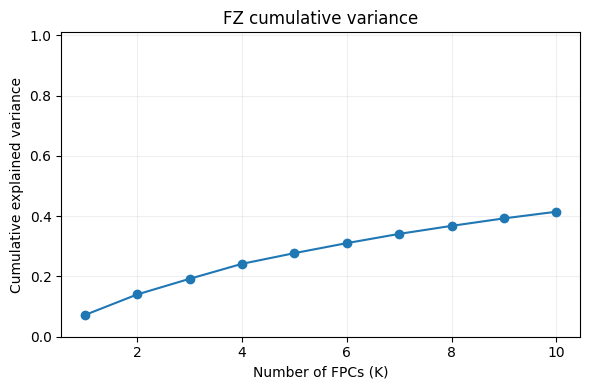

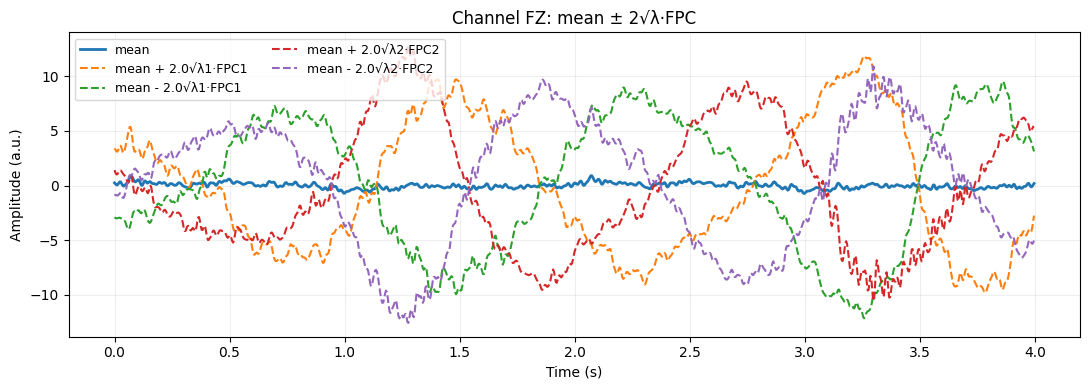

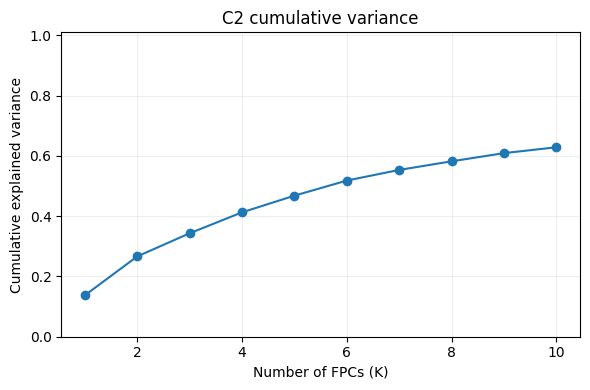

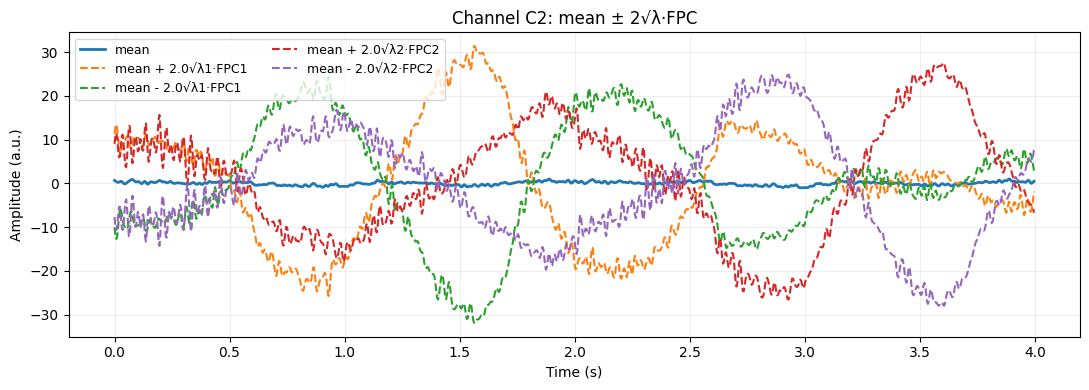


LOSO FDA per-channel (K_ch=10) — RECORDING (log-mean pooled logits)
Confusion matrix:
 [[ 8  2  5]
 [ 5 16  9]
 [ 2  7  6]]
              precision    recall  f1-score   support

           0      0.533     0.533     0.533        15
           1      0.640     0.533     0.582        30
           2      0.300     0.400     0.343        15

    accuracy                          0.500        60
   macro avg      0.491     0.489     0.486        60
weighted avg      0.528     0.500     0.510        60

Balanced Accuracy: 0.48888888888888893
Accuracy: 0.5

LOSO FDA per-channel (K_ch=10) — WINDOW
Confusion matrix:
 [[295 302 238]
 [238 405 298]
 [178 259 307]]
              precision    recall  f1-score   support

           0      0.415     0.353     0.382       835
           1      0.419     0.430     0.425       941
           2      0.364     0.413     0.387       744

    accuracy                          0.400      2520
   macro avg      0.399     0.399     0.398      2520
weighted 

In [26]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim

# -------------------------
# Plot utils (keep as you wrote)
# -------------------------
def plot_fpcs_for_channel(pca, fs=256, n_fpc=2, alpha=2.0, title=""):
    mean = pca.mean_
    comps = pca.components_
    lam = pca.explained_variance_
    T = mean.shape[0]
    t = np.arange(T) / fs

    plt.figure(figsize=(11, 4))
    plt.plot(t, mean, linewidth=2, label="mean")

    for j in range(n_fpc):
        phi = comps[j]
        amp = alpha * np.sqrt(lam[j])
        plt.plot(t, mean + amp*phi, linestyle="--", label=f"mean + {alpha}√λ{j+1}·FPC{j+1}")
        plt.plot(t, mean - amp*phi, linestyle="--", label=f"mean - {alpha}√λ{j+1}·FPC{j+1}")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (a.u.)")
    plt.title(title if title else "FPC shapes")
    plt.grid(alpha=0.2)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()

def plot_explained_variance(pca, title=""):
    cum = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
    plt.ylim(0, 1.01)
    plt.xlabel("Number of FPCs (K)")
    plt.ylabel("Cumulative explained variance")
    plt.title(title if title else "Cumulative variance")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

# -------------------------
# Minimal dataset for FDA (numpy-based)
# -------------------------
from torch.utils.data import Dataset

class WindowDatasetFDA(Dataset):
    def __init__(self, X_all, y_all, rec_id_all, keep_rec_set):
        rec_id_all = np.asarray(rec_id_all).astype(str).reshape(-1)
        mask = np.isin(rec_id_all, list(keep_rec_set))
        self.X = np.asarray(X_all)[mask]
        self.y = np.asarray(y_all)[mask]
        self.r = rec_id_all[mask]

    def __len__(self): return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i], self.r[i]

def get_numpy_from_ds(ds):
    # Assumes ds.X is (Nwin, 8, 1024), ds.y (Nwin,), ds.r (Nwin,)
    return np.asarray(ds.X), np.asarray(ds.y).astype(int), np.asarray(ds.r).astype(str)

# -------------------------
# ONE training on windows (imbalance-aware) returning TEST logits + preds
# -------------------------
def train_one_mlp_windows_return_logits(
    Xtr_w, ytr_w,
    Xva_w, yva_w,
    Xte_w, yte_w,
    num_classes,
    device,
    max_epochs=300, patience=30, lr=1e-3, wd=1e-4, tau=1.0
):
    # scale (fit train only)
    scaler = StandardScaler()
    Xtr_np = scaler.fit_transform(Xtr_w)
    Xva_np = scaler.transform(Xva_w)
    Xte_np = scaler.transform(Xte_w)

    Xtr = torch.tensor(Xtr_np, dtype=torch.float32, device=device)
    Xva = torch.tensor(Xva_np, dtype=torch.float32, device=device)
    Xte = torch.tensor(Xte_np, dtype=torch.float32, device=device)
    ytr = torch.tensor(ytr_w, dtype=torch.long, device=device)
    yva = torch.tensor(yva_w, dtype=torch.long, device=device)

    clf = MLP(Xtr.shape[1], num_classes).to(device)

    # imbalance-aware loss (same as EEGPT)
    counts = np.bincount(np.asarray(ytr_w).astype(int), minlength=num_classes)
    crit = LogitAdjustedCE(counts, tau=tau).to(device)
    opt  = optim.AdamW(clf.parameters(), lr=lr, weight_decay=wd)

    @torch.no_grad()
    def val_balacc():
        clf.eval()
        pred = clf(Xva).argmax(1).detach().cpu().numpy()
        return balanced_accuracy_score(np.asarray(yva_w).astype(int), pred)

    best, best_state, noimp = -1, None, 0
    for _ in range(max_epochs):
        clf.train()
        opt.zero_grad(set_to_none=True)
        loss = crit(clf(Xtr), ytr)
        loss.backward()
        opt.step()

        va = val_balacc()
        if va > best:
            best = va
            best_state = {k: v.detach().cpu().clone() for k, v in clf.state_dict().items()}
            noimp = 0
        else:
            noimp += 1
            if noimp >= patience:
                break

    if best_state is not None:
        clf.load_state_dict(best_state)

    with torch.no_grad():
        clf.eval()
        logits_te = clf(Xte).detach().cpu().numpy()  # (Nwin_te, C)
        pred_te = logits_te.argmax(axis=1)

    return pred_te, logits_te

# ============================================================
# 0) Window-level source of truth
# ============================================================
X_win_all = X_all
y_win_all = y_all
rec_id_win = meta["rec_id"].astype(str)
subj_win   = meta["subject"].astype(str)

assert X_win_all.shape[0] == len(y_win_all) == len(rec_id_win) == len(subj_win), \
    "Mismatch: assicurati che X_all/y_all/meta siano window-level!"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = int(np.max(y_win_all) + 1)

# recordings and subjects (recording->subject from rec_id string as you did)
rec_ids = np.unique(rec_id_win)
rec_subjects = np.array([rid.split("|")[-1] for rid in rec_ids])
subjects = np.unique(rec_subjects)

# ============================================================
# 1) LOSO loop FDA: per-channel + global
#    SINGLE TRAINING per fold (windows) + recording pooling logits
# ============================================================
K_ch   = 10
K_glob = 80

# per-channel
all_true_ch_rec, all_pred_ch_rec = [], []
all_true_ch_win, all_pred_ch_win = [], []

# global
all_true_g_rec,  all_pred_g_rec  = [], []
all_true_g_win,  all_pred_g_win  = [], []

for s in subjects:
    # --- split recording-level: test subject s
    test_rec = set(rec_ids[rec_subjects == s])
    trainval_rec = rec_ids[rec_subjects != s]
    trainval_subjects = rec_subjects[rec_subjects != s]

    # --- train/val split within trainval (group by subject)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, va_idx = next(gss.split(trainval_rec, groups=trainval_subjects))
    train_rec = set(trainval_rec[tr_idx])
    val_rec   = set(trainval_rec[va_idx])

    # --- datasets window-level
    train_ds = WindowDatasetFDA(X_win_all, y_win_all, rec_id_win, train_rec)
    val_ds   = WindowDatasetFDA(X_win_all, y_win_all, rec_id_win, val_rec)
    test_ds  = WindowDatasetFDA(X_win_all, y_win_all, rec_id_win, test_rec)

    # --- numpy windows
    Xtr_raw, ytr_w, rtr = get_numpy_from_ds(train_ds)
    Xva_raw, yva_w, rva = get_numpy_from_ds(val_ds)
    Xte_raw, yte_w, rte = get_numpy_from_ds(test_ds)

    # ==========================================================
    # (A) FDA per-channel features
    # ==========================================================
    Ftr_w, Fva_w, Fte_w, pca_list = make_fda_features_per_channel(Xtr_raw, Xva_raw, Xte_raw, K=K_ch)

    # --- ONE TRAINING (windows) -> window preds + logits
    pred_ch_win, logits_ch_win = train_one_mlp_windows_return_logits(
        Ftr_w, ytr_w, Fva_w, yva_w, Fte_w, yte_w,
        num_classes=num_classes, device=device, tau=1.0
    )

    # window-level accumulation
    all_true_ch_win.extend(yte_w.tolist())
    all_pred_ch_win.extend(pred_ch_win.tolist())

    # recording-level via log-mean pooling of WINDOW logits (NO retrain)
    rec_list_ch, pred_ch_rec, _ = recording_pool_logmean_from_logits(logits_ch_win, rte)
    true_ch_rec = recording_true_from_windows(yte_w, rte, rec_list_ch)

    all_true_ch_rec.extend(true_ch_rec.tolist())
    all_pred_ch_rec.extend(pred_ch_rec.tolist())

    # optional FPC plots for first subject
    if s == subjects[0]:
        channel_names = ["FP1","FP2","F7","F3","FZ","F4","F8","C2"]
        for ch_idx in [4, 7]:  # FZ e C2
            plot_explained_variance(pca_list[ch_idx], title=f"{channel_names[ch_idx]} cumulative variance")
            plot_fpcs_for_channel(
                pca_list[ch_idx],
                fs=256,
                n_fpc=2,
                alpha=2.0,
                title=f"Channel {channel_names[ch_idx]}: mean ± 2√λ·FPC"
            )

    # ==========================================================
    # (B) FDA global features
    # ==========================================================
    Gtr_w, Gva_w, Gte_w, _ = make_fda_features_global_zpca(Xtr_raw, Xva_raw, Xte_raw, K=K_glob)

    pred_g_win, logits_g_win = train_one_mlp_windows_return_logits(
        Gtr_w, ytr_w, Gva_w, yva_w, Gte_w, yte_w,
        num_classes=num_classes, device=device, tau=1.0
    )

    # window-level accumulation
    all_true_g_win.extend(yte_w.tolist())
    all_pred_g_win.extend(pred_g_win.tolist())

    # recording-level via log-mean pooling of WINDOW logits (NO retrain)
    rec_list_g, pred_g_rec, _ = recording_pool_logmean_from_logits(logits_g_win, rte)
    true_g_rec = recording_true_from_windows(yte_w, rte, rec_list_g)

    all_true_g_rec.extend(true_g_rec.tolist())
    all_pred_g_rec.extend(pred_g_rec.tolist())

# ============================================================
# 2) Final reports
# ============================================================

print("\n==============================")
print(f"LOSO FDA per-channel (K_ch={K_ch}) — RECORDING (log-mean pooled logits)")
print("==============================")
cm = confusion_matrix(all_true_ch_rec, all_pred_ch_rec)
print("Confusion matrix:\n", cm)
print(classification_report(all_true_ch_rec, all_pred_ch_rec, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true_ch_rec, all_pred_ch_rec))
print("Accuracy:", accuracy_score(all_true_ch_rec, all_pred_ch_rec))

print("\n==============================")
print(f"LOSO FDA per-channel (K_ch={K_ch}) — WINDOW")
print("==============================")
cm = confusion_matrix(all_true_ch_win, all_pred_ch_win)
print("Confusion matrix:\n", cm)
print(classification_report(all_true_ch_win, all_pred_ch_win, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true_ch_win, all_pred_ch_win))
print("Accuracy:", accuracy_score(all_true_ch_win, all_pred_ch_win))

print("\n==============================")
print(f"LOSO FDA global (K_glob={K_glob}) — RECORDING (log-mean pooled logits)")
print("==============================")
cm = confusion_matrix(all_true_g_rec, all_pred_g_rec)
print("Confusion matrix:\n", cm)
print(classification_report(all_true_g_rec, all_pred_g_rec, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true_g_rec, all_pred_g_rec))
print("Accuracy:", accuracy_score(all_true_g_rec, all_pred_g_rec))

print("\n==============================")
print(f"LOSO FDA global (K_glob={K_glob}) — WINDOW")
print("==============================")
cm = confusion_matrix(all_true_g_win, all_pred_g_win)
print("Confusion matrix:\n", cm)
print(classification_report(all_true_g_win, all_pred_g_win, digits=3))
print("Balanced Accuracy:", balanced_accuracy_score(all_true_g_win, all_pred_g_win))
print("Accuracy:", accuracy_score(all_true_g_win, all_pred_g_win))

# sanity prints
print("X_all:", np.shape(X_all))
print("y_all:", np.shape(y_all))
print('meta["rec_id"]:', np.shape(meta["rec_id"]))
print('meta["subject"]:', np.shape(meta["subject"]))




## t-SNE su FDA a livello recording (stesso stile del tuo TSN)

In [27]:
Xtr_rec, ytr_rec, Xva_rec, yva_rec, Xte_rec, yte_rec = tsne_cache["ch"]
tsne_plot(Xtr_rec, ytr_rec, Xva_rec, yva_rec, Xte_rec, yte_rec,
          title=f"t-SNE FDA per-channel (K={K_ch})")

Xtr_rec_g, ytr_rec_g, Xva_rec_g, yva_rec_g, Xte_rec_g, yte_rec_g = tsne_cache["g"]
tsne_plot(Xtr_rec_g, ytr_rec_g, Xva_rec_g, yva_rec_g, Xte_rec_g, yte_rec_g,
          title=f"t-SNE FDA global (K={K_glob})")


NameError: name 'tsne_cache' is not defined